In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from skimage.transform import resize
from collections import defaultdict

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import scipy.ndimage
from sklearn.utils import class_weight

In [2]:
from tensorflow.keras import layers

# Core layers you’ll likely need:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Dense,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    BatchNormalization,
    Activation,
    Add,
    Concatenate,
    Dropout,
    Flatten
)

In [3]:

### CLAHE ADJUSTED IMAGES
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/clahe_resized_images' # currently resized image input (224 x 224)

### Lanczos Interpolated Images
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/lanczos_resized_images' # currently resized image input (224 x 224)

### Lanczos and Clahe Interpolated Images
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/lanczos_and_clahe_resized_images' # currently resized image input (224 x 224)

### CLAHE Images that have not been masked out
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/clahe_no_nc_without_masking_resized_images' # currently resized image input (224 x 224)

### CLAHE Images that have not been masked out with median filtering
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/clahe_no_nc_without_masking_median_filtering_resized_images' # currently resized image input (224 x 224)

# CLAHE Images that have not been masked out with srad noise reduction
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/clahe_no_nc_without_masking_srad_resized_images' # currently resized image input (224 x 224)

# Images with only N&C that have not been masked out
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/only_nc_no_masking_resized_images' # currently resized image input (224 x 224)

# Images with only N&C that have not been masked out, focusing of 40% of 2023 patients (ID < 133) and 60% 2024 patients
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/only_nc_no_masking_60_percent_newer_resized_images' # currently resized image input (224 x 224)

### Lanczos Interpolated Images, only containing 2024 patients (ID > 133)
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/lanczos_100_percent_newer_resized_images' # currently resized image input (224 x 224)

### Lanczos Interpolated Images that are shape corrected
B_MODE_IMAGE_FOLDER = '/content/drive/MyDrive/Hikaru_Colab_Workspace/lanczos_shape_corrected_only_nc_resized_images' # currently resized image input (224 x 224)

### Envelope Images that are shape corrected, only containing 2024 patients (ID > 133)
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/env_only_newer_resized_images' # currently resized image input (224 x 224)

### B-Mode Reconstructed Images that are shape corrected, containing the entire viewpoint, no cropping/masking
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/only_nc_entire_viewpoint_resized_images' # currently resized image input (224 x 224)

### B-Mode Reconstructed Images that are shape corrected, with only cropping applied, no masking
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/only_nc_no_masking_new_cropping_method_resized_images' # currently resized image input (224 x 224)

### Envolope Reconstructed Images that are shape corrected, containing the entire viewpoint, no cropping/masking
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/env_entire_viewpoint_resized_images' # currently resized image input (224 x 224)

### CLAHE Image that have not been normalized and clipped beforehand
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/clahe_no_nc_resized_images' # currently resized image input (224 x 224)

### Lanczos Interpolated Images that are shape corrected, only selecting largest mask per patient
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/lanczos_shape_corrected_only_largest_mask_resized_images' # currently resized image input (224 x 224)

# Cloud Images
# IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/cloud_resized_images' # currently resized image input (224 x 224)

# H-scan Images
H_SCAN_IMAGE_FOLDER = '/content/drive/MyDrive/Hikaru_Colab_Workspace/hscan_resized_images' # currently resized image input (224 x 224)

### ORIGINAL IMAGES
# IMAGE_FOLDER = '/content/drive/MyDrive/eGFR_Prediction_US_Image_Project/Kidney_image_Preprocessing/Resized_(224 x 224)_matlab/Resized_Images (224 x 224)' # currently resized image input (224 x 224)
# CSV_FILE = '/content/drive/MyDrive/uttiya_test_lab/patient_eGFR_at_pocus_2025.csv'
# CSV_FILE = '/content/drive/MyDrive/uttiya_test_lab/patient_eGFR_at_pocus_2025_polynomial_estimation.csv'
# CSV_FILE = '/content/drive/MyDrive/uttiya_test_lab/patient_slopes_2025_polynomial_estimations.csv'
CSV_FILE = '/content/drive/MyDrive/Hikaru_Colab_Workspace/patient_eGFR_at_pocus_2025_Jul_polynomial_estimation.csv'
#CSV_FILE = '/content/drive/MyDrive/Hikaru_Colab_Workspace/patient_slopes_2025_Jul_polynomial_estimations.csv'
# CSV_FILE = '/content/drive/MyDrive/uttiya_test_lab/patient_avg_egfr_3_to_12_months.csv'
BATCH_SIZE = 16 # batch = 8 -> 10% batch = 16 --> doesnt work
EPOCHS = 160 # epoch = 40 --> 10% epoch = 50 --> 9%
SEED = 42

## 1. Data Loading & Preprocessing

In [4]:
# Patient class used to hold all information related for training
class Patient:
    def __init__(self, patient_id, egfr, b_mode_image_paths, h_scan_image_paths):
        self.patient_id = patient_id
        self.egfr = egfr
        self.b_mode_image_paths = b_mode_image_paths
        self.h_scan_image_paths = h_scan_image_paths

    def __repr__(self):
        return (f"Patient({self.patient_id}, eGFR={self.egfr}, "
                f"# of B-mode={len(self.b_mode_image_paths)}, "
                f"# of H-scan={len(self.h_scan_image_paths)})")

def label_img_classification_by_patient(b_mode_folder, h_scan_folder, csv_file):
    eGFR_data = pd.read_csv(csv_file)
    eGFR_data.rename(columns={'Patient ID': 'patient_id', 'eGFR (abs/closest)': 'eGFR'}, inplace=True)
    eGFR_data['patient_id'] = eGFR_data['patient_id'].astype(int)
    eGFR_data.set_index('patient_id', inplace=True)

    patient_image_map = defaultdict(lambda: {"b_mode": [], "h_scan": []})

    # Collect all files in both folders
    b_mode_files = set(os.listdir(b_mode_folder))
    h_scan_files = set(os.listdir(h_scan_folder))

    # Match only filenames that exist in both
    common_files = sorted(b_mode_files.intersection(h_scan_files))
    missing_in_hscan = b_mode_files - h_scan_files
    missing_in_bmode = h_scan_files - b_mode_files

    # Log missing files
    for f in missing_in_hscan:
        print(f"Skipping {f}: exists in B-mode but not in H-scan folder")
    for f in missing_in_bmode:
        print(f"Skipping {f}: exists in H-scan but not in B-mode folder")

    for filename in common_files:
        try:
            patient_id = int(filename.split('_')[1])  # adjust parsing if needed
            if patient_id in eGFR_data.index:
                b_path = os.path.join(b_mode_folder, filename)
                h_path = os.path.join(h_scan_folder, filename)
                patient_image_map[patient_id]["b_mode"].append(b_path)
                patient_image_map[patient_id]["h_scan"].append(h_path)
            else:
                print(f"Patient ID {patient_id} not found in CSV, skipping...")
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

    # Build Patient objects
    patient_objects = []
    for patient_id, paths in patient_image_map.items():
        egfr = eGFR_data.loc[patient_id, 'eGFR']
        egfrLabel = 1 if egfr >= 60 else 0 #-5
        patient_objects.append(Patient(
            patient_id,
            egfrLabel,
            paths["b_mode"],
            paths["h_scan"]
        ))

    return patient_objects

def preprocess_img(img_path, grayscale=False):
    image = tf.io.read_file(img_path)
    if grayscale:
        image = tf.image.decode_png(image, channels=1)  # read as single channel
        image = tf.image.grayscale_to_rgb(image)        # expand to 3 channels
    else:
        image = tf.image.decode_png(image, channels=3)  # keep RGB

    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.keras.utils.img_to_array(image)

# def preprocess_img(img_path, grayscale=False):
#     image = tf.io.read_file(img_path)
#     if grayscale:
#         image = tf.image.decode_png(image, channels=1)  # single channel
#     else:
#         image = tf.image.decode_png(image, channels=3)
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     return image  # shape: (H,W,1) for grayscale

# WIP: NEW DATA AUGMENT SYSTEM
I really don't like the ImageDataGenerator
- Its deprecated
- It created random results
- It only performs 1 operation (ex. horizontal flip or vertical flip or crop)
- This WIP system should just take each image, and create multiple images from it, using every operation

In [5]:
def augment_images_dual(b_mode_images, h_scan_images, labels, random_state):
    """Generate augmented image pairs (b_mode, h_scan).
       Augmentations are applied identically to both images in the pair.
       Returns arrays of b_mode, h_scan, and labels.
    """
    augmented_b = b_mode_images.copy()
    augmented_h = h_scan_images.copy()
    augmented_labels = labels.copy()

    deterministic_random_number_gen = np.random.default_rng(random_state)

    for b_img, h_img, label in zip(b_mode_images, h_scan_images, labels):

        # 1. Horizontal flip
        augmented_b.append(np.fliplr(b_img))
        augmented_h.append(np.fliplr(h_img))
        augmented_labels.append(label)

        # 2. Random rotation (-40 to 40 degrees)
        angle = deterministic_random_number_gen.integers(-40, 40)
        rotated_b = scipy.ndimage.rotate(b_img, angle, reshape=False, mode='constant', cval=1)
        rotated_h = scipy.ndimage.rotate(h_img, angle, reshape=False, mode='constant', cval=1)
        augmented_b.append(rotated_b)
        augmented_h.append(rotated_h)
        augmented_labels.append(label)

        # 3. Another random rotation
        angle = deterministic_random_number_gen.integers(-40, 40)
        rotated_b = scipy.ndimage.rotate(b_img, angle, reshape=False, mode='constant', cval=1)
        rotated_h = scipy.ndimage.rotate(h_img, angle, reshape=False, mode='constant', cval=1)
        augmented_b.append(rotated_b)
        augmented_h.append(rotated_h)
        augmented_labels.append(label)

        # 4. Random square crop
        height, width = b_img.shape[:2]
        random_array = deterministic_random_number_gen.random(size=4)
        w = int((width * 0.90) * (1 + random_array[0] * 0.10))
        h = w
        x = int(random_array[2] * (width - w))
        y = int(random_array[3] * (height - h))

        crop_b = b_img[y:h+y, x:w+x, 0:3]
        crop_h = h_img[y:h+y, x:w+x, 0:3]

        crop_b = resize(crop_b, b_img.shape, anti_aliasing=True)
        crop_h = resize(crop_h, h_img.shape, anti_aliasing=True)

        augmented_b.append(crop_b)
        augmented_h.append(crop_h)
        augmented_labels.append(label)

    return np.array(augmented_b), np.array(augmented_h), np.array(augmented_labels)


#temporarily comment out
# # Takes a set of patients
# # and reads their images into memory, optionally performing augmentation of the images
# def create_dataset_from_patients(patients, augment=False, batch_size=4):
#     # Load paired images
#     b_mode_images = [preprocess_img(path, grayscale=True)
#                      for patient in patients for path in patient.b_mode_image_paths]
#     h_scan_images = [preprocess_img(path, grayscale=False)
#                      for patient in patients for path in patient.h_scan_image_paths]
#     labels = [patient.egfr for patient in patients for _ in patient.b_mode_image_paths]

#     if augment:
#         b_mode_images, h_scan_images, labels = augment_images_dual(
#             list(b_mode_images), list(h_scan_images), list(labels), SEED
#         )

#     # Build dataset with tuple of inputs
#     dataset = tf.data.Dataset.from_tensor_slices(((b_mode_images, h_scan_images), labels))
#     dataset = dataset.batch(batch_size)
#     return dataset

#for augmentation
import tensorflow as tf

# Define Keras augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.1),
])

# data_augmentation = tf.keras.Sequential([
#             tf.keras.layers.RandomFlip("horizontal"),  # horizontal flip
#             tf.keras.layers.RandomTranslation(
#                 height_factor=0.3,  # vertical shift up to 30%
#                 width_factor=0.3    # horizontal shift up to 30%
#             ),
#         ])

def augment_pair(b_mode, h_scan):
    # Concatenate along channels -> shape (H, W, 6)
    combined = tf.concat([b_mode, h_scan], axis=-1)

    # Apply augmentation
    augmented = data_augmentation(combined, training=True)

    # Split back into two (H, W, 3) tensors
    b_aug = augmented[..., :3]   # first 3 channels
    h_aug = augmented[..., 3:]   # last 3 channels

    return b_aug, h_aug


def create_dataset_from_patients(patients, augment=False, batch_size=4):
    # Load paired images
    b_mode_images = [preprocess_img(path, grayscale=True)
                     for patient in patients for path in patient.b_mode_image_paths]
    h_scan_images = [preprocess_img(path, grayscale=False)
                     for patient in patients for path in patient.h_scan_image_paths]
    labels = [patient.egfr for patient in patients for _ in patient.b_mode_image_paths]

    dataset = tf.data.Dataset.from_tensor_slices(((b_mode_images, h_scan_images), labels))
    dataset = dataset.batch(batch_size)

    if augment:
        dataset = dataset.map(
            lambda x, y: ((augment_pair(x[0], x[1])), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    return dataset


#for h scan only
# def create_dataset_from_patients_hscan_only(patients, augment=False, batch_size=4):
#     """
#     Creates a tf.data.Dataset using only H-scan images for the dense-only model.
#     Converts images to grayscale and normalizes to [0,1].
#     """
#     h_scan_images = [
#         preprocess_img(path, grayscale=True)  # force grayscale
#         for patient in patients
#         for path in patient.h_scan_image_paths
#     ]
#     labels = [
#         patient.egfr
#         for patient in patients
#         for _ in patient.h_scan_image_paths
#     ]

#     #if augment:
#         # Optional: add augmentation for H-scan images
#     #    h_scan_images, labels = augment_images_hscan(list(h_scan_images), list(labels), SEED)

#     # Convert to tf.data.Dataset
#     dataset = tf.data.Dataset.from_tensor_slices((h_scan_images, labels))
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     return dataset


In [ ]:
# 1. Get file paths and labels
# file_paths, eGFR_labels, absolute_file_paths_indices = label_img(IMAGE_FOLDER, CSV_FILE)
patients = label_img_classification_by_patient(B_MODE_IMAGE_FOLDER, H_SCAN_IMAGE_FOLDER, CSV_FILE)

# # 2. Split into train, validation, and test sets
# train_paths, test_paths, train_labels, test_labels = train_test_split(
#     file_paths, eGFR_labels, test_size=0.2, random_state=42
# )

# # 3. Create data pipeline
# train_dataset = create_dataset(train_paths, train_labels, datagen, augment=True, batch_size=BATCH_SIZE)  # Apply augmentation
# test_dataset = create_dataset(test_paths, test_labels, datagen, augment=False, batch_size=BATCH_SIZE)

# # 4. Check the pipeline
# for images, labels in train_dataset.take(1):
#     print(images.shape, labels.shape)  # Output: (batch_size, image_height, image_width, 1) (batch_size,)
#     print("Image shape:", images[0].shape)
#     print("Label:", labels[0])

#     # Plot the images and labels
#     plt.figure(figsize=(10, 10))
#     for i in range(BATCH_SIZE):
#         plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().squeeze(), cmap='gray')
#         plt.title(f"eGFR: {labels[i].numpy():.2f}")
#         plt.axis('off')

Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128

## 2. CNN model with extra layers with Max pooling

In [ ]:
def build_small_cnn():
    model = models.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(224, 224, 1)))

    # Block 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))  # 112 x 112

    # Block 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))  # 56 x 56

    # Block 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))  # 28 x 28

    '''
    Block 4 and 5 Used in Zero Padding image
    '''
    # # Block 4
    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))  # 129x129

    # # Block 5
    # model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))  # 64x64

    # Fully connected layers for regression
    model.add(layers.GlobalAveragePooling2D())
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='linear'))  # Regression output

    return model

model = build_small_cnn()
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # try huber instead of mse for outliers --> huber do great job to reduce errors but not great for the result
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,521 (107.50 KB)

 Trainable params: 27,521 (107.50 KB)

 Non-trainable params: 0 (0.00 B)

two branch architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def build_dual_cnn_model():
    """
    Dual-input CNN model:
      - Two branches process inputs separately with Conv layers
      - Feature maps concatenated (same spatial size preserved)
      - Converging conv path -> pooling -> dense -> output
    """

    # ---- Branch 1 ----
    input1 = Input(shape=(224, 224, 3), name="branch1_input")
    x1 = layers.Conv2D(32, (3,3), padding="same", activation="relu")(input1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x1)
    x1 = layers.BatchNormalization()(x1)

    # ---- Branch 2 ----
    input2 = Input(shape=(224, 224, 3), name="branch2_input")
    x2 = layers.Conv2D(32, (3,3), padding="same", activation="relu")(input2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)

    # ---- Fusion ----
    merged = layers.Concatenate(axis=-1)([x1, x2])  # shape stays (224,224,128)

    # ---- Converging Conv path ----
    merged = layers.Conv2D(128, (3,3), padding="same", activation="relu")(merged)
    merged = layers.BatchNormalization()(merged)
    merged = layers.Conv2D(256, (3,3), padding="same", activation="relu")(merged)
    merged = layers.BatchNormalization()(merged)

    # ---- Global pooling & Dense ----
    merged = layers.GlobalAveragePooling2D()(merged)
    merged = layers.Dense(512, activation="relu")(merged)
    merged = layers.Dropout(0.25)(merged)
    merged = layers.Dense(128, activation="relu")(merged)
    merged = layers.Dropout(0.25)(merged)
    output = layers.Dense(1, activation="sigmoid")(merged)

    # ---- Build model ----
    model = models.Model(inputs=[input1, input2], outputs=output)
    return model


# Example usage
model = build_dual_cnn_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ branch1_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch2_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ branch1_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │        896 │ branch2_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │    147,584 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    131,584 │ global_average_p

 Total params: 681,217 (2.60 MB)

 Trainable params: 680,065 (2.59 MB)

 Non-trainable params: 1,152 (4.50 KB)

# Resnet Model

In [ ]:
def build_dual_resnet_model(with_transfer_learning=True):
    """
    Builds a dual-input ResNet model for paired B-mode and H-scan images
    with hardcoded RadImageNet ResNet50 weights.
    """
    # Hardcoded weight path
    weight_path = '/content/drive/MyDrive/Hikaru_Colab_Workspace/model_weights/RadImageNet-ResNet50_notop.h5'

    # ---------- B-mode branch (grayscale -> RGB) ----------
    input_bmode = Input(shape=(224, 224, 3), name="bmode_input")
    base_bmode = tf.keras.applications.ResNet50(
        weights=None,
        include_top=False,
        input_shape=(224, 224, 3),
        name="resnet50_bmode"
    )
    if with_transfer_learning:
        base_bmode.load_weights(weight_path, by_name=True, skip_mismatch=False)
    base_bmode.trainable = True
    x1 = base_bmode(input_bmode)
    #x1 = layers.GlobalAveragePooling2D()(x1)

    # ---------- H-scan branch (RGB directly) ----------
    input_hscan = Input(shape=(224, 224, 3), name="hscan_input")
    base_hscan = tf.keras.applications.ResNet50(
        weights=None,
        include_top=False,
        input_shape=(224, 224, 3),
        name="resnet50_hscan"
    )
    if with_transfer_learning:
        base_hscan.load_weights(weight_path, by_name=True, skip_mismatch=False)
    base_hscan.trainable = True
    x2 = base_hscan(input_hscan)
    #x2 = layers.GlobalAveragePooling2D()(x2)

     # ---------- Fusion (keep spatial maps) ----------
    combined = layers.Concatenate(axis=-1)([x1, x2])  # shape: (7, 7, 4096)

    # ---------- Post-fusion Conv layers ----------
    combined = layers.Conv2D(1024, (3, 3), padding="same", activation="relu")(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(combined)
    combined = layers.BatchNormalization()(combined)

    # ---------- Pool & Dense ----------
    combined = layers.GlobalAveragePooling2D()(combined)
    combined = layers.Dense(1024, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(512, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)

    model = models.Model(inputs=[input_bmode, input_hscan], outputs=output)
    return model

    # # ---------- Fusion ----------
    # combined = layers.Concatenate()([x1, x2])
    # combined = layers.Dense(4096, activation='relu')(combined)
    # combined = layers.Dropout(0.3)(combined)
    # combined = layers.Dense(2048, activation='relu')(combined)
    # combined = layers.Dropout(0.2)(combined)
    # combined = layers.Dense(1024, activation='relu')(combined)
    # combined = layers.Dropout(0.2)(combined)
    # output = layers.Dense(1, activation='sigmoid')(combined)

    # model = models.Model(inputs=[input_bmode, input_hscan], outputs=output)
    # return model

# Create and compile the model outside the function
model = build_dual_resnet_model(True)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00000001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bmode_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hscan_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_bmode      │ (None, 7, 7,      │ 23,587,712 │ bmode_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_hscan      │ (None, 7, 7,      │ 23,587,712 │ hscan_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7,      │          0 │ resnet50_bmode[0… │
│ (Concatenate)       │ 4096)             │            │ resnet50_hscan[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7,      │ 37,749,760 │ concatenate[0][0] │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7,      │      4,096 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 512) │  4,719,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 512) │      2,048 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 256) │  1,179,904 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    263,168 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        513 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,619,841 (349.50 MB)

 Trainable params: 91,510,017 (349.08 MB)

 Non-trainable params: 109,824 (429.00 KB)

h_scan_only_with_dense_connections

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def build_dense_only_hscan_model():
    """
    Builds a simple neural net that takes only H-scan input,
    flattens the image, and uses dense layers for classification.
    """
    # H-scan input
    input_hscan = Input(shape=(224, 224, 1), name="hscan_input")


    # Flatten the raw pixel values
    x = layers.Flatten()(input_hscan)

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Output layer (binary classification)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_hscan, outputs=output)
    return model

# Create and compile the model
model = build_dense_only_hscan_model()
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hscan_input (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,854,977 (98.63 MB)

 Trainable params: 25,854,977 (98.63 MB)

 Non-trainable params: 0 (0.00 B)

# VGG Model

In [ ]:
def build_vgg_model(with_transfer_learning):
    if with_transfer_learning:
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True

    model = models.Sequential([
        # layers.Input(shape=(224, 224, 1)), # Define an Input layer with the desired shape
        # layers.Conv2D(3, (3, 3), padding='same', activation='relu'), # Convert grayscale to 3 channels
        base_model,
        # layers.Flatten(input_shape=(7, 7, 512)),  # Equivalent to PyTorch's view(output.size(0), -1)
        layers.GlobalAveragePooling2D(),  # Replace Flatten
        layers.Dense(4096, activation='relu', ),
        layers.Dropout(0.3),
        layers.Dense(2048, activation='relu', ),
        layers.Dropout(0.2),
        layers.Dense(1024, activation='relu',),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),

        # kernel_regularizer=regularizers.l2(0.01)
    ])
    return model

# Create and compile the model outside the function
model = build_vgg_model(True)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,305,793 (104.16 MB)

 Trainable params: 27,305,793 (104.16 MB)

 Non-trainable params: 0 (0.00 B)

##DenseNet Model

In [ ]:
def build_densenet_model(with_transfer_learning):
    if with_transfer_learning:
        base_model = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))
        base_model.load_weights('/content/drive/MyDrive/Hikaru_Colab_Workspace/model_weights/RadImageNet-DenseNet121_notop.h5')
    else:
        base_model = tf.keras.applications.DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True

    model = models.Sequential([
      # layers.Input(shape=(224, 224, 1)), # Define an Input layer with the desired shape
      # layers.Conv2D(3, (3, 3), padding='same', activation='relu'), # Convert grayscale to 3 channels
      base_model,
      # layers.Flatten(input_shape=(7, 7, 512)),  # Equivalent to PyTorch's view(output.size(0), -1)
      layers.GlobalAveragePooling2D(),  # Replace Flatten
      layers.Dense(4096, activation='relu', ),
      layers.Dropout(0.3),
      layers.Dense(2048, activation='relu', ),
      layers.Dropout(0.2),
      layers.Dense(1024, activation='relu',),
      layers.Dropout(0.2),
      layers.Dense(1, activation='sigmoid'),

      # kernel_regularizer=regularizers.l2(0.01)
    ])
    return model

# Create and compile the model outside the function
model = build_densenet_model(True)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Hikaru_Colab_Workspace/model_weights/RadImageNet-DenseNet121_notop.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Regular Training (No K-Fold)

Epoch 1/160
     51/Unknown 20s 161ms/step - loss: 2600.7026 - mae: 43.3409

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - loss: 2577.4355 - mae: 43.0708 - val_loss: 488.0611 - val_mae: 18.4355
Epoch 2/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 478.1259 - mae: 17.8574 - val_loss: 469.1387 - val_mae: 17.8728
Epoch 3/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 474.7974 - mae: 17.7521 - val_loss: 451.5459 - val_mae: 17.4118
Epoch 4/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 463.9834 - mae: 17.6067 - val_loss: 435.5868 - val_mae: 17.0118
Epoch 5/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 454.7634 - mae: 17.4865 - val_loss: 422.5016 - val_mae: 16.6852
Epoch 6/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 447.5145 - mae: 17.3780 - val_loss: 411.4232 - val_mae: 16.3785
Epoch 7/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 441.6769 - mae: 17.2814 - val_loss: 402.4321 - val_mae: 16.1378
Epoch 8/160
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 436.6779 - mae: 17.1834 - val_loss: 394.8564 - val_mae: 15.9469
Epoch 9/160
51/51

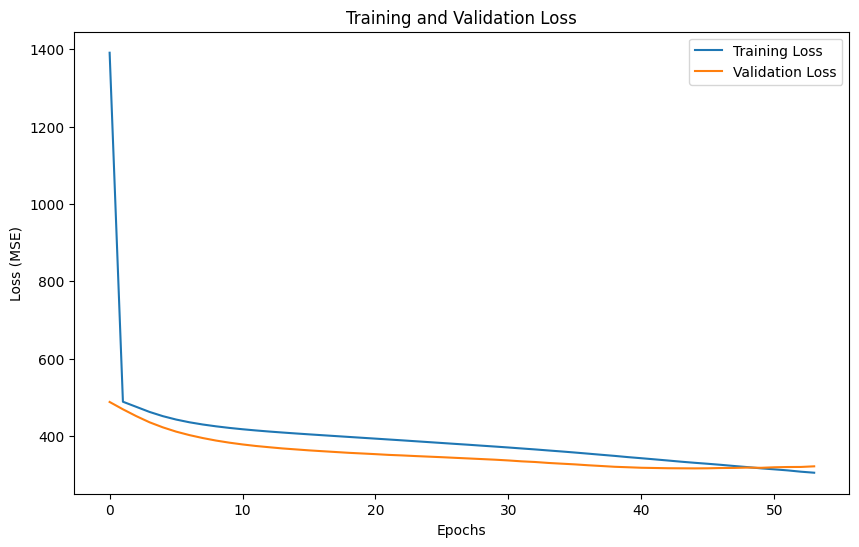

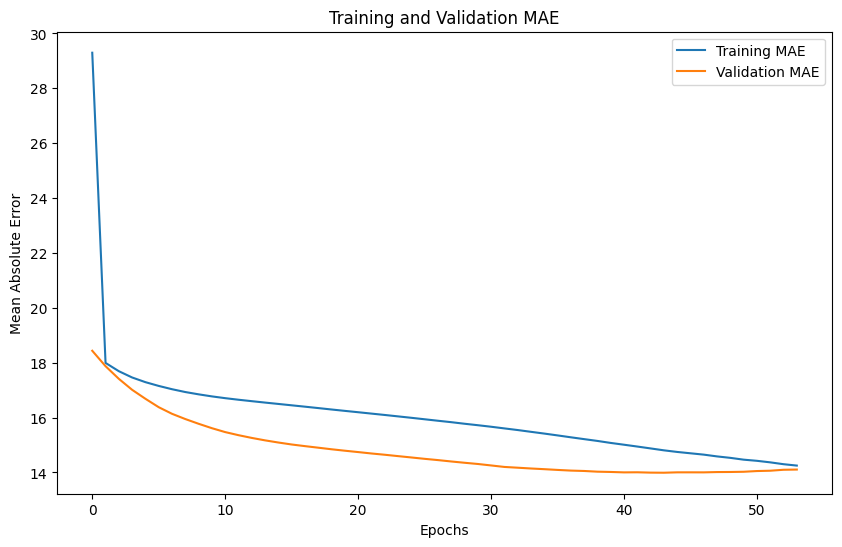

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


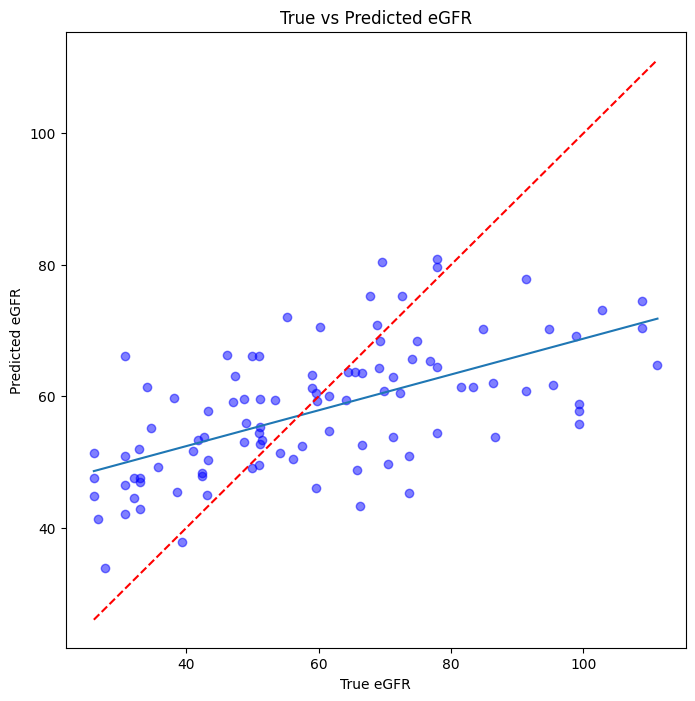

Correlation between True and Predicted eGFR: 0.60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 332.3717 - mae: 14.7185
Test Loss: 316.60400390625, Test MAE: 13.99086856842041
Mean Absolute Error (MAE): 13.99
Root Mean Squared Error (RMSE): 17.79
R² Score: 0.33


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Visualize feature maps
def visualize_feature_maps(model, img_path, layer_indices=None):
    # Load and preprocess the image
    img = preprocess_img(img_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Define a new model to output intermediate layer activations
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # Get feature maps
    feature_maps = activation_model.predict(img)

    # Plot feature maps
    for idx, feature_map in enumerate(feature_maps):
        if layer_indices and idx not in layer_indices:
            continue

        num_filters = feature_map.shape[-1]  # Number of filters
        size = feature_map.shape[1]  # Size of feature map

        plt.figure(figsize=(15, 15))
        for i in range(num_filters):
            plt.subplot(num_filters // 8 + 1, 8, i + 1)
            plt.imshow(feature_map[0, :, :, i], cmap='viridis')
            plt.axis('off')

        plt.suptitle(f"Feature Maps for Layer {idx + 1}")
        plt.show()

# Example: Visualize feature maps for an image
# for images, _ in test_dataset.take(1):
#     img_path = file_paths[0]  # Ensure this matches an actual path from your dataset
#     visualize_feature_maps(model, img_path, layer_indices=[0, 1, 2])  # Visualize layers selectively


# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Predict on the test set
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(labels.numpy().flatten())
    predicted_labels.extend(preds.flatten())



# Plot True vs Predicted eGFR
plt.figure(figsize=(8, 8))
plt.scatter(true_labels, predicted_labels, c='blue', alpha=0.5)
# Draw line of best fit for the prediction (to show trend)
plt.plot(np.unique(true_labels), np.poly1d(np.polyfit(true_labels, predicted_labels, 1))(np.unique(true_labels)))

plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--')  # Perfect prediction line
plt.xlabel('True eGFR')
plt.ylabel('Predicted eGFR')
plt.title('True vs Predicted eGFR')
plt.show()

correlation = np.corrcoef(true_labels, predicted_labels)[0, 1]
print(f"Correlation between True and Predicted eGFR: {correlation:.2f}")


# Evaluate
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

# Compute metrics
mae = mean_absolute_error(true_labels, predicted_labels)
rmse = np.sqrt(mean_squared_error(true_labels, predicted_labels))
r2 = r2_score(true_labels, predicted_labels)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


# Training with K-Fold

In [ ]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=SEED) # 5 folds

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='min', patience=60, restore_best_weights=True
)

# Convert continuous labels into bins (e.g., 5 bins)

numpy_eGFR_labels = np.array(eGFR_labels)

n_bins = min(7, len(np.unique(numpy_eGFR_labels)))  # Ensure bins do not exceed unique values

# Apply Stratified K-Fold using the binned labels
skf = StratifiedKFold(n_splits=min(5, len(numpy_eGFR_labels)), shuffle=True, random_state=SEED)  # Ensure n_splits doesn't exceed data size

# Initialize global containers to collect results from all folds
all_true_labels = []
all_predicted_labels = []
all_predicted_raw_labels = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(numpy_eGFR_labels)), numpy_eGFR_labels)):
  print("Train indices:", list(map(int, train_index)), "Test indices:", list(map(int, val_index)))
  y_train, y_val = numpy_eGFR_labels[train_index], numpy_eGFR_labels[val_index]
  print(f"Fold {fold + 1}: Train class counts: {np.bincount(y_train)}, Val class counts: {np.bincount(y_val)}")

# for fold, (train_index, val_index) in enumerate(kfold.split(file_paths)):
#   print(f"Fold {fold + 1}")

  # Split data for this fold
  train_paths_fold = [file_paths[i] for i in train_index]
  val_paths_fold = [file_paths[i] for i in val_index]
  train_labels_fold = [eGFR_labels[i] for i in train_index]
  val_labels_fold = [eGFR_labels[i] for i in val_index]

  # Plot a histogram with n_bins
  plt.hist(train_labels_fold, bins=n_bins, alpha=0.5, label='Training Data', color='blue')
  plt.hist(val_labels_fold, bins=n_bins, alpha=0.5, label='Validation Data', color='red')
  plt.xlabel('eGFR')
  plt.ylabel('Frequency')
  plt.title(f'Histogram with {n_bins} bins')
  plt.legend()
  plt.show()


  # Create datasets for this fold
  # datagen = ImageDataGenerator(**data_gen_args)
  # train_dataset_fold = create_dataset(train_paths_fold, train_labels_fold, datagen, augment=True, batch_size=BATCH_SIZE)
  # val_dataset_fold = create_dataset(val_paths_fold, val_labels_fold, datagen, augment=False, batch_size=BATCH_SIZE)
  train_dataset_fold = create_dataset_wip(train_paths_fold, train_labels_fold, augment=True, batch_size=BATCH_SIZE)
  val_dataset_fold = create_dataset_wip(val_paths_fold, val_labels_fold, augment=False, batch_size=BATCH_SIZE)

  # Build and compile the model (if necessary)
  model = build_resnet_model()
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model for this fold
  history = model.fit(
      train_dataset_fold,
      validation_data=val_dataset_fold,
      epochs=EPOCHS,
      callbacks=[early_stopping]
  )

  ### Print fold number
  print(f"Fold {fold + 1}")
  print(f"Fold {fold + 1}")
  print(f"Fold {fold + 1}")
  print(f"Fold {fold + 1}")


  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  # Plot Accuracy
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()

  # Predict on the test set
  true_labels = []
  predicted_labels = []
  predicted_raw_labels = []
  # List of tuples with format (true_value, predicted_value, abs_error, image, filename)
  errors = []

  imageIndex = 0
  for images, labels in val_dataset_fold:
      raw_preds = model.predict(images)

      preds = (raw_preds.flatten() > 0.5).astype(int)
      labels = labels.numpy().flatten()
      abs_errors = np.abs(preds - labels)

      true_labels.extend(labels)
      predicted_labels.extend(preds)
      predicted_raw_labels.extend(raw_preds.flatten())

      for i in range(len(abs_errors)):
        img = images[i].numpy().squeeze()
        errors.append((labels[i], preds[i], abs_errors[i], img, os.path.basename(val_paths_fold[imageIndex + i])))

      imageIndex += len(images)

      # Accumulate across all folds
      all_true_labels.extend(labels)
      all_predicted_labels.extend(preds)
      all_predicted_raw_labels.extend(raw_preds.flatten())


  # Sort by abs_error in descending order
  errors.sort(key=lambda x: x[2], reverse=True)

  # Evaluate
  results = model.evaluate(val_dataset_fold)
  print(true_labels)
  print(predicted_labels)
  accuracy = accuracy_score(true_labels, predicted_labels)
  print(f"Accuracy: {accuracy:.2f}")

  print(classification_report(true_labels, predicted_labels, target_names=["eGFR < 60", "eGFR ≥ 60"]))

  # Compute ROC curve and AUC
  fpr, tpr, thresholds = roc_curve(true_labels, predicted_raw_labels)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve with Keras Model')
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

  # Print and show top 5 outliers (makes no sense in classification still useful for QA)
  # For example, it ensures images we feed in did not get corrupted (through broken code)
  top_5_outliers = errors[:5]

  # Plot all 5 images in a single figure
  plt.figure(figsize=(20, 5))
  for i, (true, pred, abs_err, img, filename) in enumerate(top_5_outliers):
      # Arrange in 1 row, 5 columns
      plt.subplot(1, 5, i + 1)
      plt.imshow(img, cmap="gray")
      plt.axis("off")
      plt.title(f"True: {true:.2f}\nPred: {pred:.2f}\nErr: {abs_err:.2f} \n{filename}")

  plt.suptitle("Top 5 Worst Outliers", fontsize=16)
  plt.show()

# === After all folds: Final analysis ===

fpr, tpr, _ = roc_curve(all_true_labels, all_predicted_raw_labels)
roc_auc = auc(fpr, tpr)

# Plot final ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve (All K-Folds Combined)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print metrics
print(f"\n=== Final Evaluation Across All Folds ===")
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"\nFinal Accuracy: {accuracy:.2f}")
print("\nFinal Classification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=["eGFR < 60", "eGFR ≥ 60"]))



# Training With K-Fold (Patient Exclusivity)

[8, 10, 15, 17, 18, 19, 26, 27, 28, 32, 33, 35, 36, 41, 43, 47, 49, 50, 51, 52, 56, 59, 60, 63, 64, 77, 78, 79, 80, 81, 82, 83, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 107, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 133, 134, 137, 138, 139, 143, 145, 146, 147, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 182, 183, 185, 186, 188, 189, 190, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 215, 217, 219, 220, 221, 223, 224, 225, 227, 228, 229, 230, 231, 232, 237, 238, 239, 240, 241, 242, 243, 244, 245, 248, 249, 251, 253, 254, 255, 256, 258, 259, 261, 266, 267, 270, 271, 272, 274]
Train indices: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 13, 16, 17, 18, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 56, 57, 58, 59, 61, 63, 64, 65, 67, 68, 70, 71, 72

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


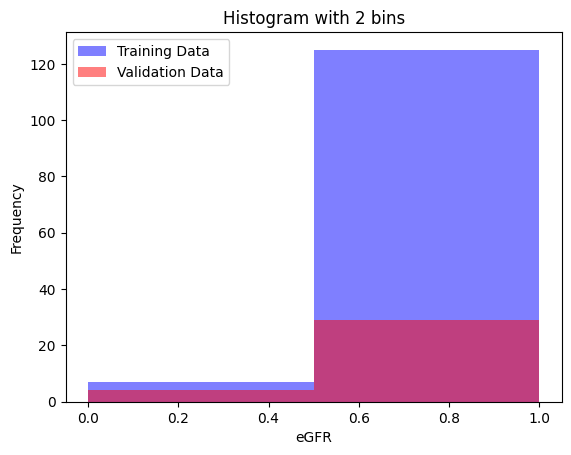

Epoch 1/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 715ms/step - accuracy: 0.7240 - loss: 0.8611 - val_accuracy: 0.8788 - val_loss: 0.4135
Epoch 2/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6686 - loss: 0.8973 - val_accuracy: 0.8788 - val_loss: 0.3991
Epoch 3/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8505 - loss: 0.6303 - val_accuracy: 0.8788 - val_loss: 0.7741
Epoch 4/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9615 - loss: 0.1891 - val_accuracy: 0.8788 - val_loss: 1.1167
Epoch 5/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9358 - loss: 0.2103 - val_accuracy: 0.8788 - val_loss: 1.2497
Epoch 6/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9744 - loss: 0.1825 - val_accuracy: 0.8788 - val_loss: 0.6942
Epoch 7/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9830 - loss: 0.0619 - val_accuracy: 0.8788 - val_loss: 1.2330
Epoch 8/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9875 - loss: 0.0171 - val_accuracy: 

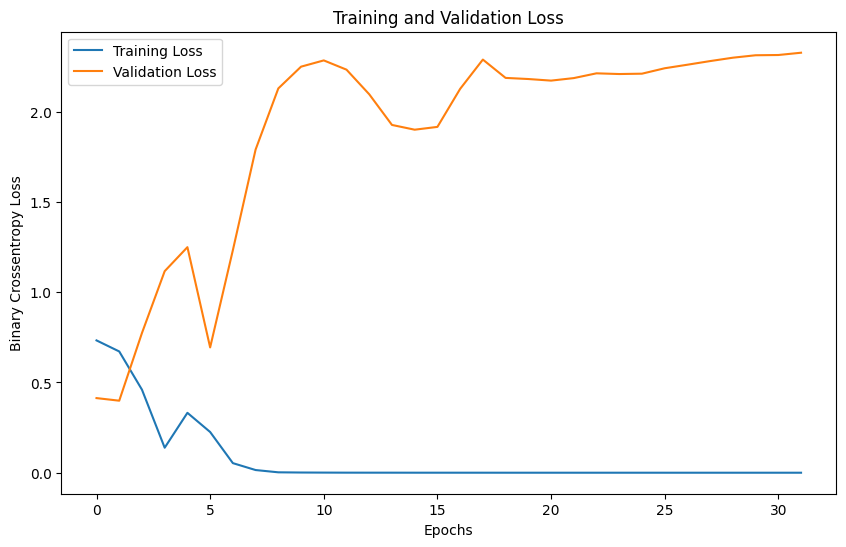

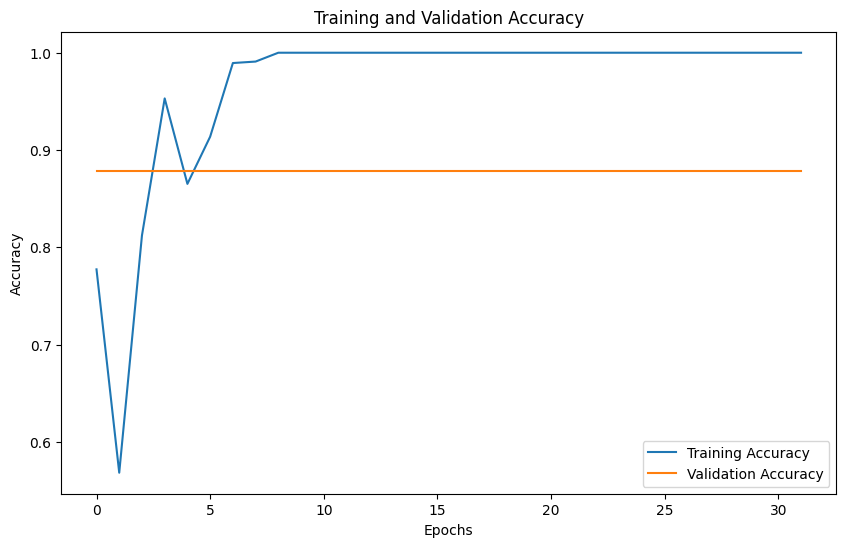

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8613 - loss: 0.4512
[np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


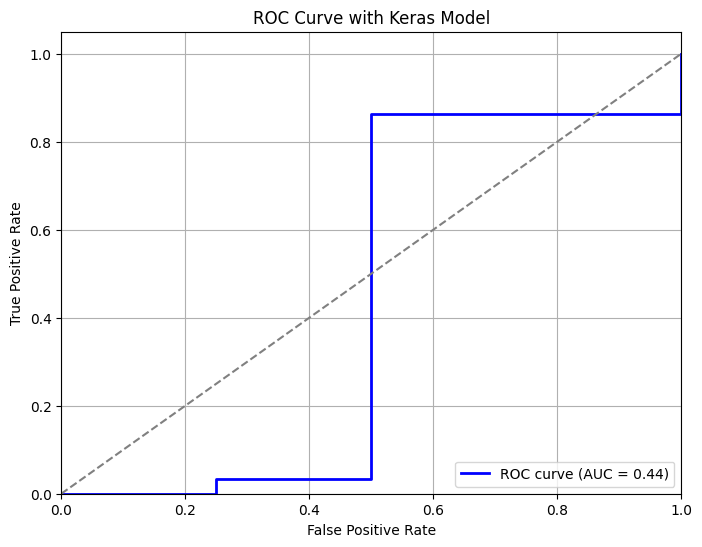

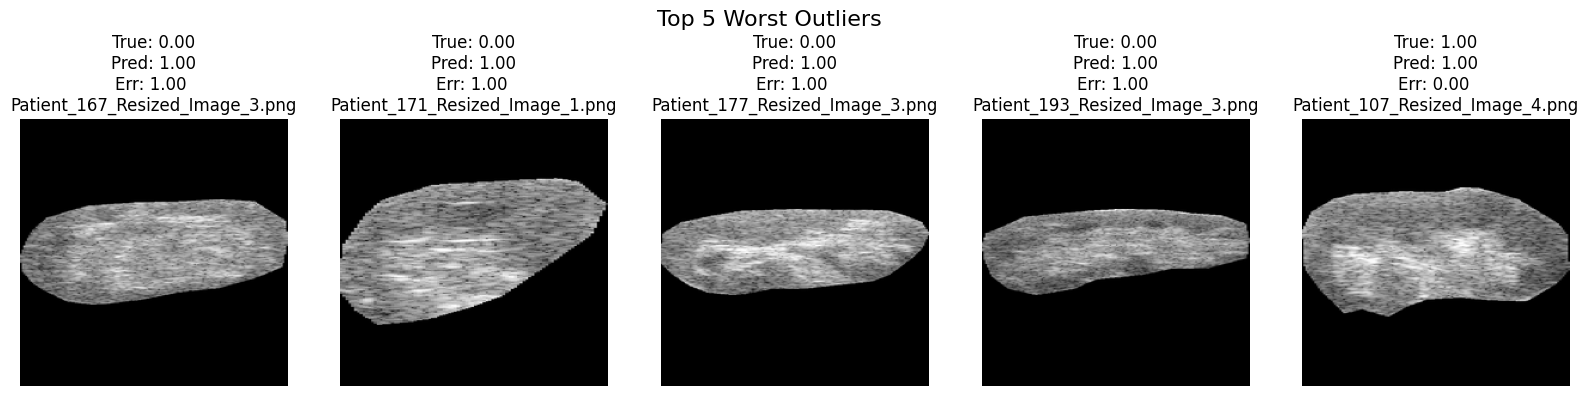

Train indices: [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 89, 91, 93, 94, 95, 97, 98, 99, 101, 102, 103, 104, 107, 108, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 135, 137, 140, 141, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164] Test indices: [3, 7, 27, 32, 36, 37, 45, 52, 58, 59, 72, 73, 76, 83, 88, 90, 92, 96, 100, 105, 106, 109, 110, 112, 125, 133, 134, 136, 138, 139, 142, 145, 148]


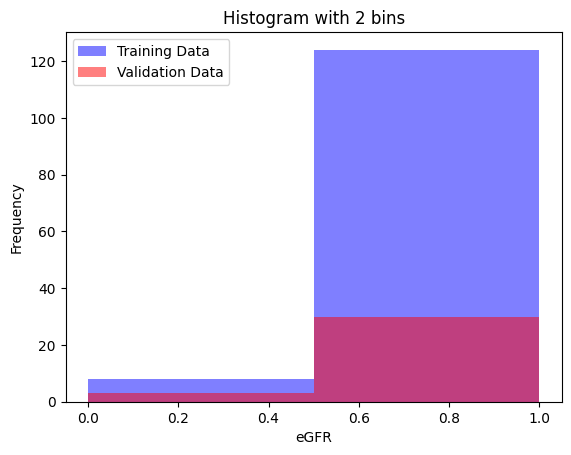

Epoch 1/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 745ms/step - accuracy: 0.7262 - loss: 1.2512 - val_accuracy: 0.0909 - val_loss: 0.7597
Epoch 2/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8009 - loss: 0.7597 - val_accuracy: 0.0909 - val_loss: 0.7437
Epoch 3/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8308 - loss: 0.6821 - val_accuracy: 0.9091 - val_loss: 0.5768
Epoch 4/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8835 - loss: 0.5724 - val_accuracy: 0.9091 - val_loss: 0.4893
Epoch 5/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9159 - loss: 0.4127 - val_accuracy: 0.9091 - val_loss: 0.9248
Epoch 6/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9701 - loss: 0.0893 - val_accuracy: 0.9091 - val_loss: 1.5073
Epoch 7/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9967 - loss: 0.0420 - val_accuracy: 0.9091 - val_loss: 1.4205
Epoch 8/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9821 - loss: 0.0325 - val_accuracy: 

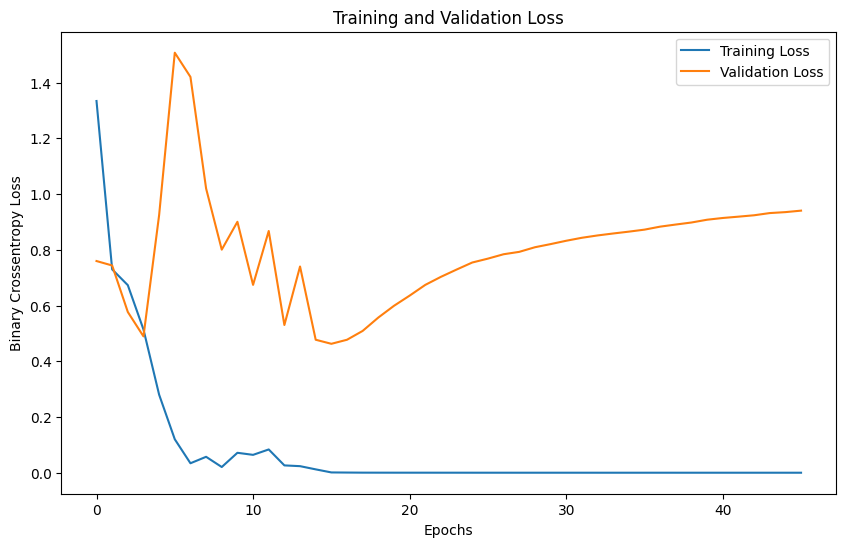

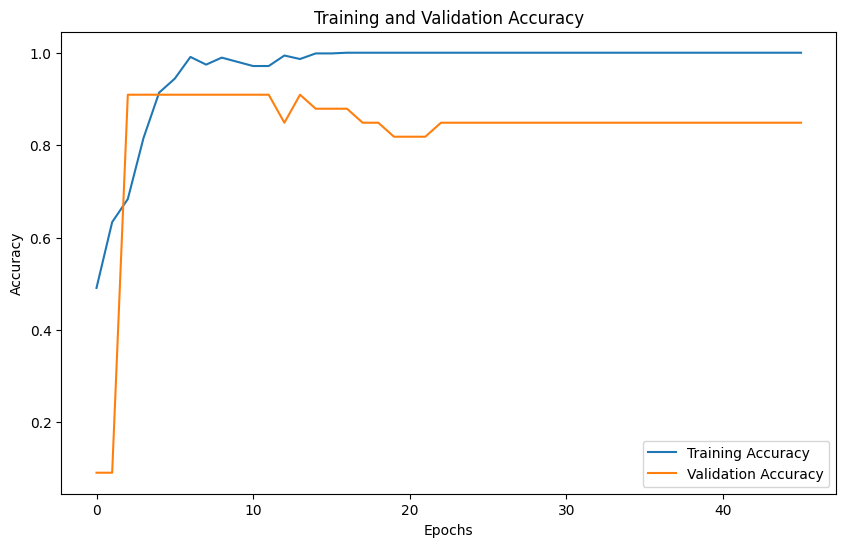

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8456 - loss: 0.5885
[np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1

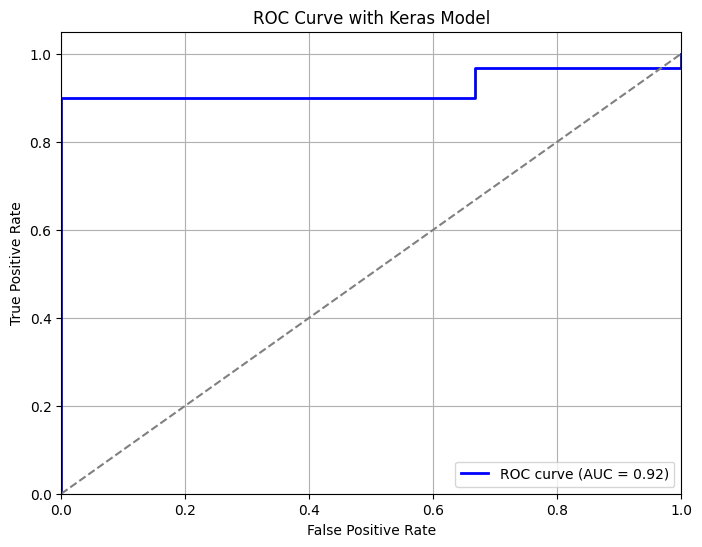

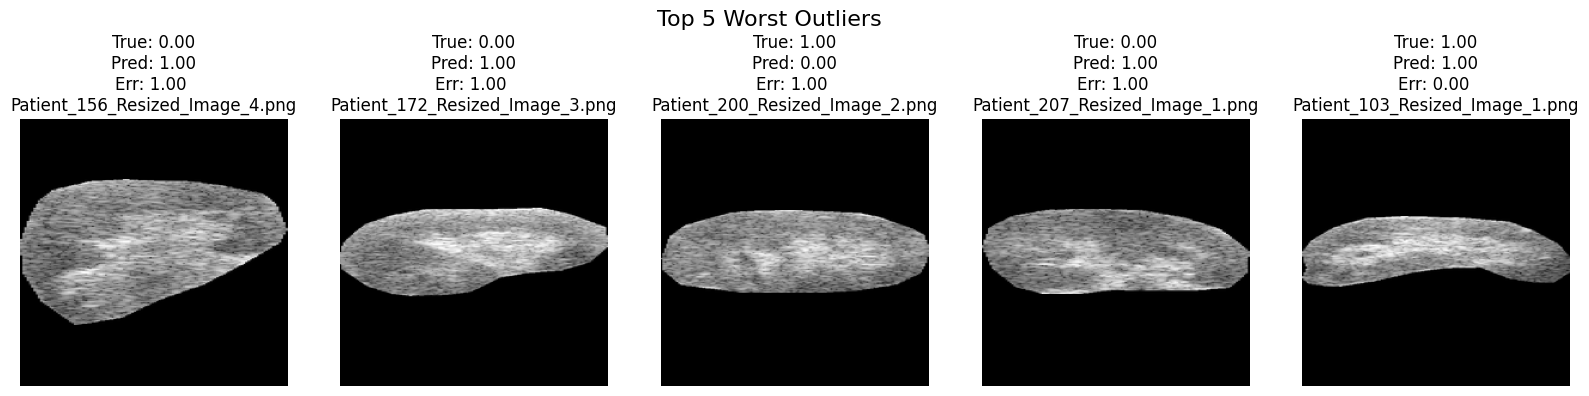

Train indices: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 34, 36, 37, 39, 40, 41, 42, 44, 45, 47, 48, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 114, 115, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159, 161, 162, 164] Test indices: [4, 11, 13, 20, 26, 31, 33, 35, 38, 43, 46, 49, 50, 53, 56, 65, 67, 81, 82, 84, 91, 107, 108, 113, 116, 117, 120, 129, 140, 155, 156, 160, 163]


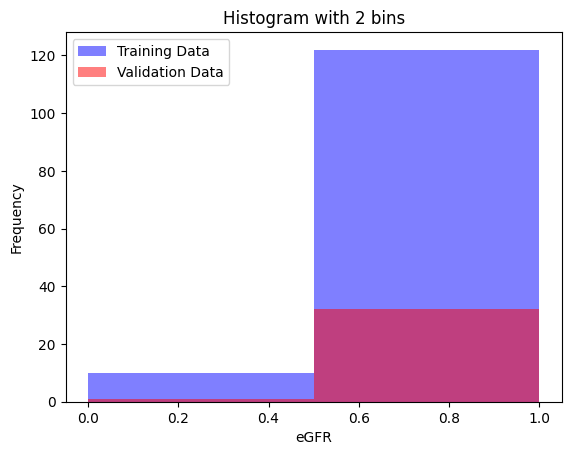

Epoch 1/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 720ms/step - accuracy: 0.5888 - loss: 0.9191 - val_accuracy: 0.9697 - val_loss: 0.3281
Epoch 2/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8144 - loss: 0.9018 - val_accuracy: 0.9697 - val_loss: 0.6161
Epoch 3/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8438 - loss: 0.7565 - val_accuracy: 0.8485 - val_loss: 0.6735
Epoch 4/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9102 - loss: 0.6774 - val_accuracy: 0.9697 - val_loss: 0.4069
Epoch 5/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9435 - loss: 0.4513 - val_accuracy: 0.9697 - val_loss: 0.1580
Epoch 6/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8896 - loss: 0.5436 - val_accuracy: 0.0303 - val_loss: 48.2771
Epoch 7/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8767 - loss: 0.3764 - val_accuracy: 0.0303 - val_loss: 23.4372
Epoch 8/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9331 - loss: 0.1770 - val_accuracy

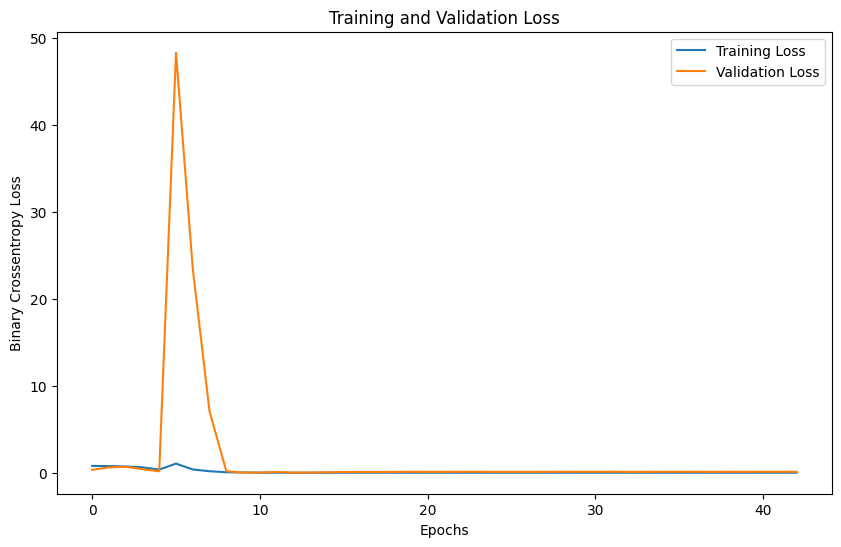

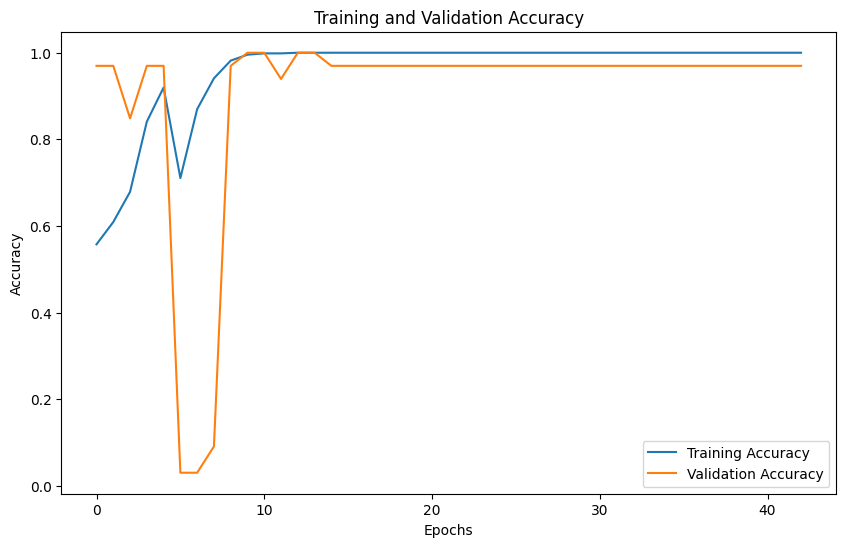

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0086    
[np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int

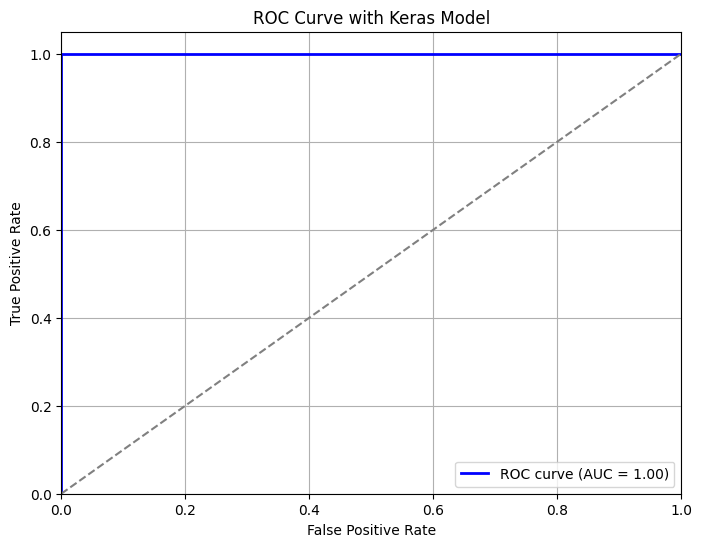

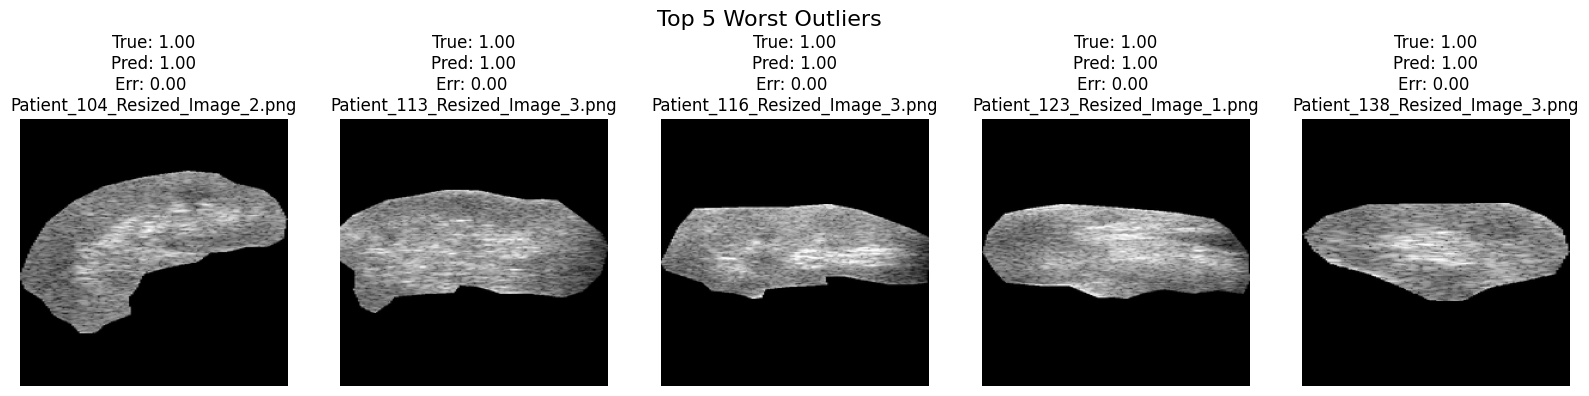

Train indices: [0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 69, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 86, 87, 88, 90, 91, 92, 96, 97, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 151, 155, 156, 158, 159, 160, 162, 163] Test indices: [1, 2, 8, 17, 42, 48, 64, 68, 70, 71, 77, 80, 85, 89, 93, 94, 95, 98, 99, 102, 103, 114, 115, 123, 135, 144, 150, 152, 153, 154, 157, 161, 164]


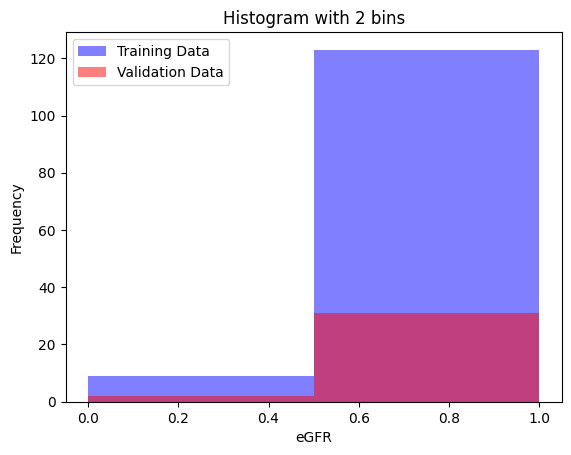

Epoch 1/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 719ms/step - accuracy: 0.7564 - loss: 0.9076 - val_accuracy: 0.2121 - val_loss: 0.6952
Epoch 2/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8173 - loss: 0.7216 - val_accuracy: 0.9394 - val_loss: 0.6602
Epoch 3/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8809 - loss: 0.6976 - val_accuracy: 0.9394 - val_loss: 0.6342
Epoch 4/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8449 - loss: 0.6636 - val_accuracy: 0.9394 - val_loss: 0.4274
Epoch 5/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8173 - loss: 0.5573 - val_accuracy: 0.9394 - val_loss: 0.2154
Epoch 6/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8721 - loss: 0.3416 - val_accuracy: 0.9394 - val_loss: 0.5452
Epoch 7/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9260 - loss: 0.2385 - val_accuracy: 0.9394 - val_loss: 0.3695
Epoch 8/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9003 - loss: 0.2509 - val_accuracy: 

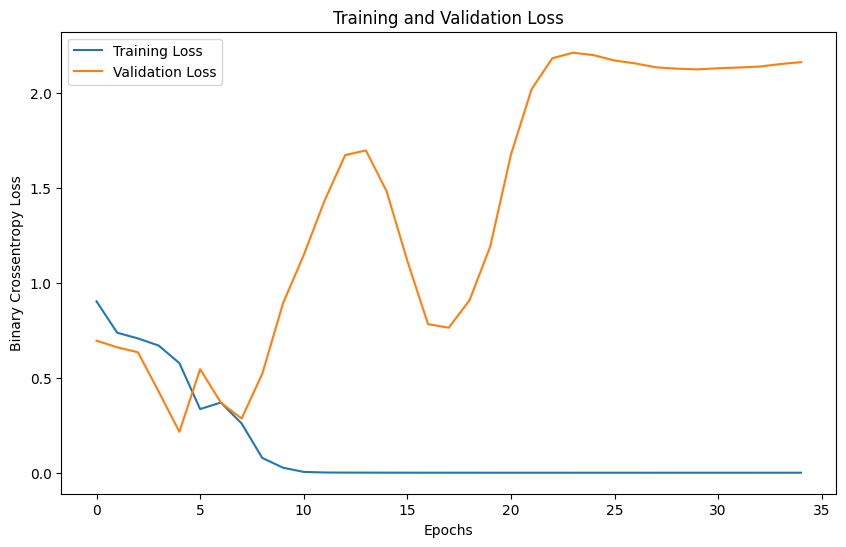

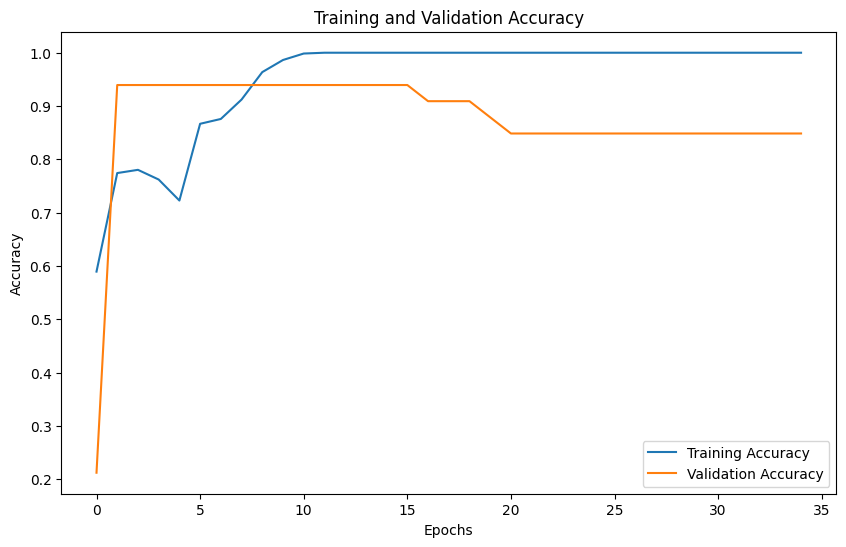

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9228 - loss: 0.2529
[np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


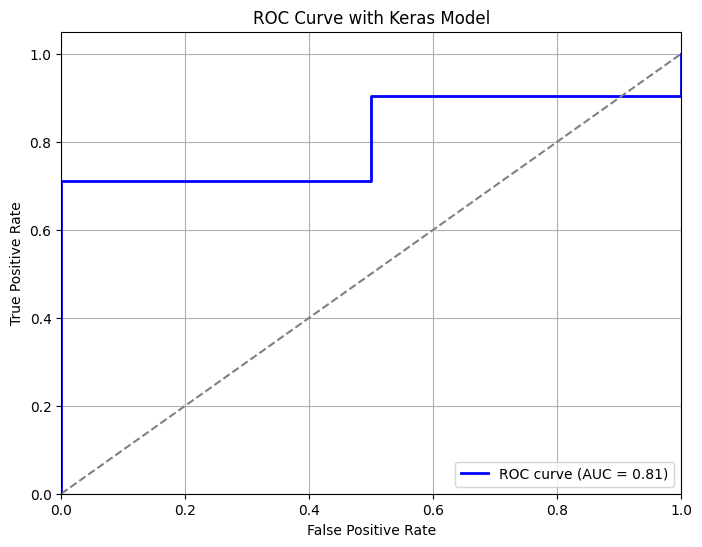

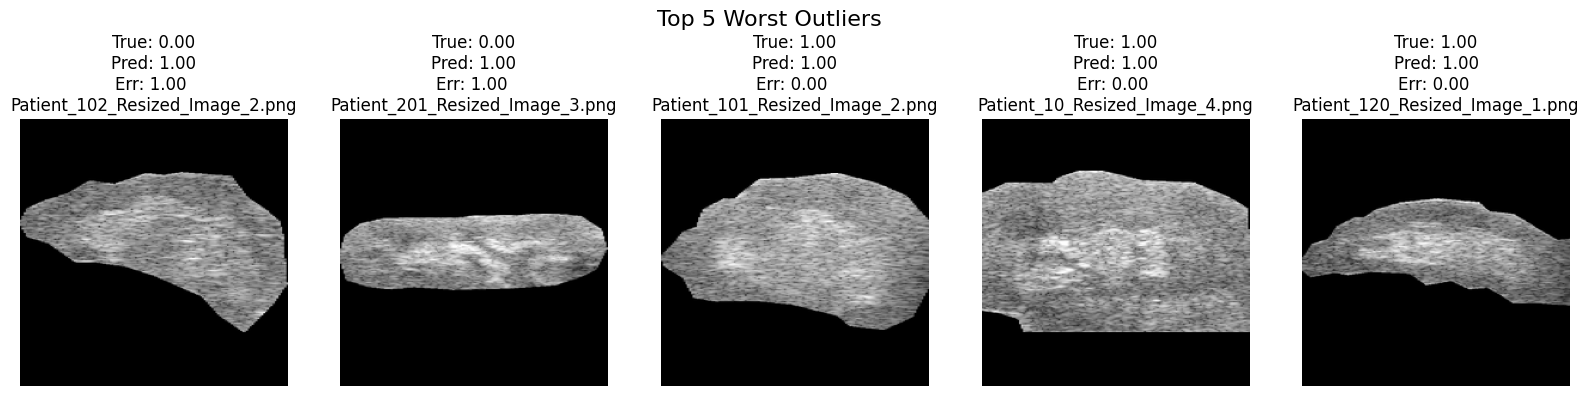

Train indices: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 120, 121, 123, 124, 125, 127, 128, 129, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144, 145, 147, 148, 150, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164] Test indices: [0, 6, 9, 16, 18, 25, 28, 29, 30, 39, 41, 44, 57, 61, 63, 74, 86, 87, 97, 104, 118, 119, 122, 126, 130, 131, 132, 137, 143, 146, 149, 151, 158]


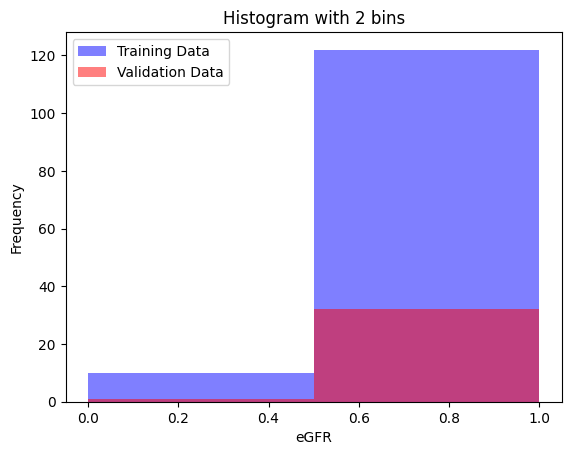

Epoch 1/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 711ms/step - accuracy: 0.4149 - loss: 0.9590 - val_accuracy: 0.9697 - val_loss: 0.5912
Epoch 2/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8281 - loss: 0.7776 - val_accuracy: 0.0909 - val_loss: 0.6990
Epoch 3/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8449 - loss: 0.7211 - val_accuracy: 0.9697 - val_loss: 0.3224
Epoch 4/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8732 - loss: 0.5781 - val_accuracy: 0.9697 - val_loss: 0.8923
Epoch 5/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9478 - loss: 0.2838 - val_accuracy: 0.9091 - val_loss: 0.9047
Epoch 6/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9603 - loss: 0.1068 - val_accuracy: 0.9697 - val_loss: 1.8800
Epoch 7/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9859 - loss: 0.0610 - val_accuracy: 0.3939 - val_loss: 6.4276
Epoch 8/160
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9838 - loss: 0.0443 - val_accuracy: 

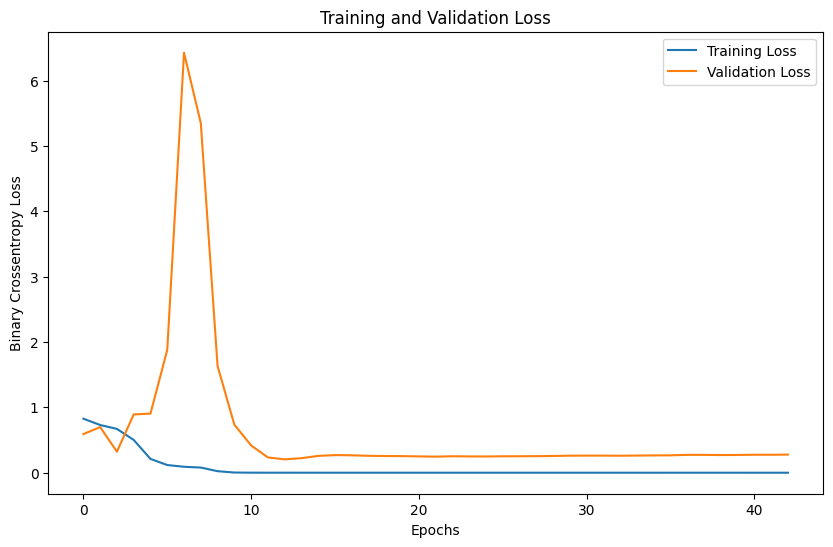

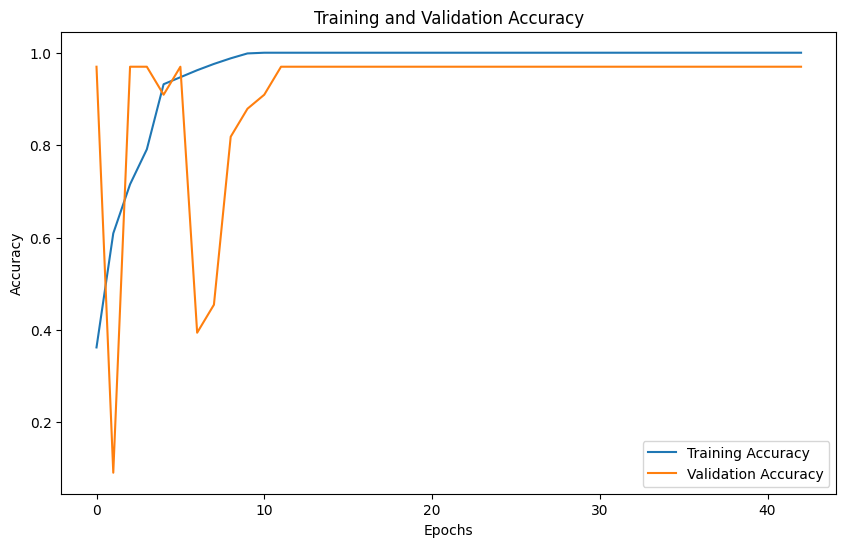

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9770 - loss: 0.1553
[np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


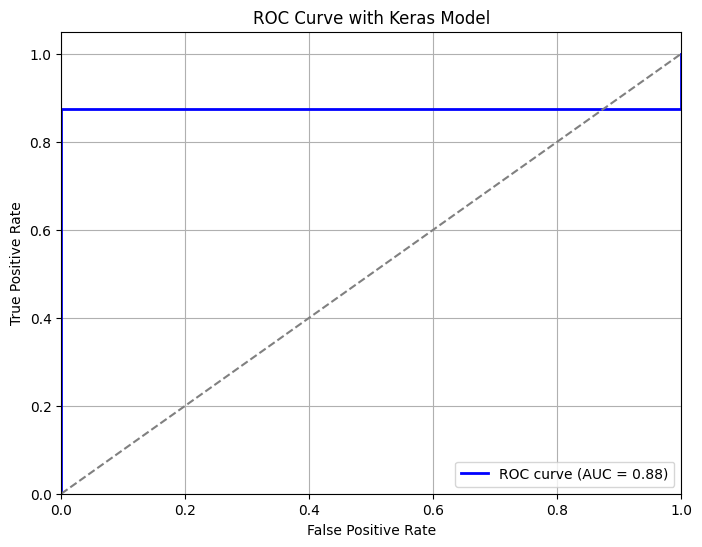

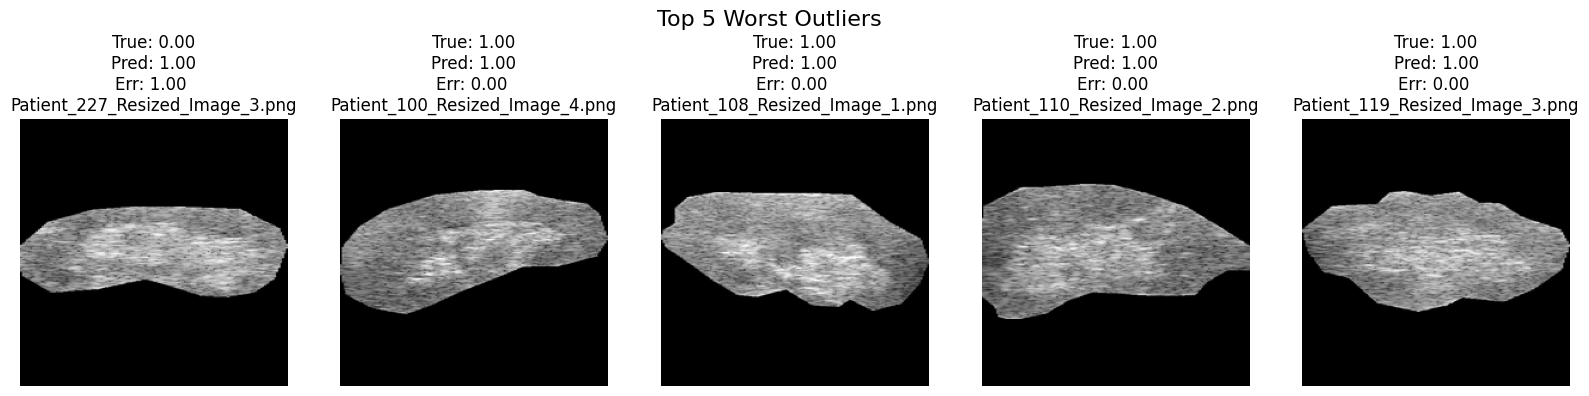

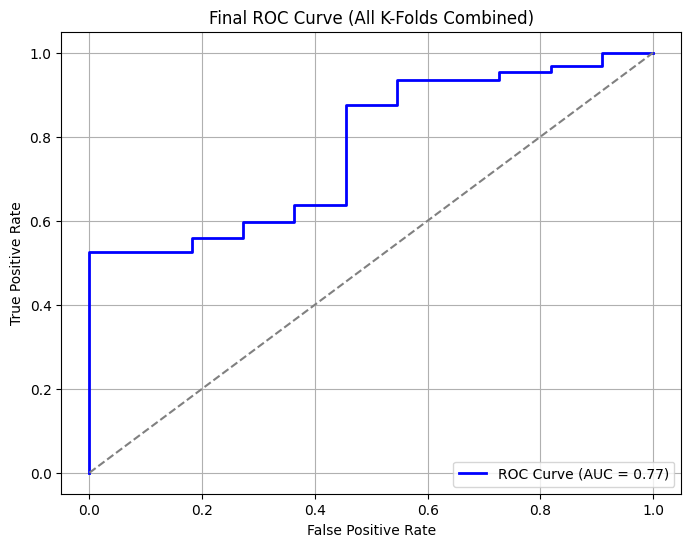


=== Final Evaluation Across All Folds ===

Final Accuracy: 0.93

Final Classification Report:
              precision    recall  f1-score   support

   eGFR < 30       0.50      0.09      0.15        11
   eGFR ≥ 30       0.94      0.99      0.97       154

    accuracy                           0.93       165
   macro avg       0.72      0.54      0.56       165
weighted avg       0.91      0.93      0.91       165



In [ ]:
# Aggregate image paths and eGFR by patient
patient_ids = [int(os.path.basename(path).split('_')[1]) for path in file_paths]
patient_to_images = defaultdict(list)
patient_to_label = {}
# Relative IDX refers to the set of indexes that contain each patient's images in the "file_paths" array
patient_to_relative_file_path_indices = defaultdict(list)
# Absolute IDX refers to the set of indexes that contains each patient's images in the filesystem IMAGE_FOLDER directory itself
# The reason this is different to relative, some files (images) are skipped when being creating the file_paths array
patient_to_absolute_file_path_indices = defaultdict(list)

for relative_idx, (abs_idx, path) in enumerate(zip(absolute_file_paths_indices, file_paths)):
    pid = int(os.path.basename(path).split('_')[1])  # Extract patient ID (e.g., '8' from 'Patient_8_...')
    patient_to_relative_file_path_indices[pid].append(relative_idx)
    patient_to_absolute_file_path_indices[pid].append(abs_idx)


for path, label, pid in zip(file_paths, eGFR_labels, patient_ids):
    patient_to_images[pid].append(path)
    patient_to_label[pid] = label  # Assumes 1 label per patient

unique_patient_ids = list(patient_to_images.keys())
print(sorted(unique_patient_ids))
labels_for_strat = [patient_to_label[pid] for pid in unique_patient_ids]


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=30, restore_best_weights=True
)

# Binning labels for stratification
n_bins = min(7, len(np.unique(labels_for_strat)))
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile', random_state=SEED)
labels_binned = kbins.fit_transform(np.array(labels_for_strat).reshape(-1, 1)).astype(int).flatten()

# Apply Stratified K-Fold using the binned labels
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)  # Ensure n_splits doesn't exceed data size

# Initialize global containers to collect results from all folds
all_true_labels = []
all_predicted_labels = []
all_predicted_raw_labels = []

for fold, (train_pid_idx, val_pid_idx) in enumerate(skf.split(unique_patient_ids, labels_binned)):
# for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(numpy_eGFR_labels)), numpy_eGFR_labels)):
  train_patient_ids = [unique_patient_ids[i] for i in train_pid_idx]
  val_patient_ids = [unique_patient_ids[i] for i in val_pid_idx]

  # Get all indices corresponding to train/val patients
  train_index = [i for pid in train_patient_ids for i in patient_to_relative_file_path_indices[pid]]
  val_index = [i for pid in val_patient_ids for i in patient_to_relative_file_path_indices[pid]]

  # For debugging purposes, print the absolute file indexes from the file system
  abs_train_index = [i for pid in train_patient_ids for i in patient_to_absolute_file_path_indices[pid]]
  abs_val_index = [i for pid in val_patient_ids for i in patient_to_absolute_file_path_indices[pid]]

  print("Train indices:", list(map(int, abs_train_index)), "Test indices:", list(map(int, abs_val_index)))

# for fold, (train_index, val_index) in enumerate(kfold.split(file_paths)):
#   print(f"Fold {fold + 1}")

  # Split data for this fold
  train_paths_fold = [file_paths[i] for i in train_index]
  val_paths_fold = [file_paths[i] for i in val_index]
  train_labels_fold = [eGFR_labels[i] for i in train_index]
  val_labels_fold = [eGFR_labels[i] for i in val_index]

  # Compute class weights
  weights = class_weight.compute_class_weight(
      class_weight='balanced',
      classes=np.unique(np.array(train_labels_fold).astype(int)),
      y=np.array(train_labels_fold).astype(int)
  )
  class_weights_dict = dict(enumerate(weights))

  # Plot a histogram with n_bins
  plt.hist(train_labels_fold, bins=n_bins, alpha=0.5, label='Training Data', color='blue')
  plt.hist(val_labels_fold, bins=n_bins, alpha=0.5, label='Validation Data', color='red')
  plt.xlabel('eGFR')
  plt.ylabel('Frequency')
  plt.title(f'Histogram with {n_bins} bins')
  plt.legend()
  plt.show()


  # Create datasets for this fold
  # datagen = ImageDataGenerator(**data_gen_args)
  # train_dataset_fold = create_dataset(train_paths_fold, train_labels_fold, datagen, augment=True, batch_size=BATCH_SIZE)
  # val_dataset_fold = create_dataset(val_paths_fold, val_labels_fold, datagen, augment=False, batch_size=BATCH_SIZE)
  train_dataset_fold = create_dataset_wip(train_paths_fold, train_labels_fold, augment=True, batch_size=BATCH_SIZE)
  val_dataset_fold = create_dataset_wip(val_paths_fold, val_labels_fold, augment=False, batch_size=BATCH_SIZE)

  # Build and compile the model (if necessary)
  model = build_resnet_model()
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model for this fold
  history = model.fit(
      train_dataset_fold,
      validation_data=val_dataset_fold,
      epochs=EPOCHS,
      callbacks=[early_stopping],
      class_weight=class_weights_dict
  )

  ### Print fold number
  print(f"Fold {fold + 1}")
  print(f"Fold {fold + 1}")
  print(f"Fold {fold + 1}")
  print(f"Fold {fold + 1}")


  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  # Plot Accuracy
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()

  # Predict on the test set
  true_labels = []
  predicted_labels = []
  predicted_raw_labels = []
  # List of tuples with format (true_value, predicted_value, abs_error, image, filename)
  errors = []

  imageIndex = 0
  for images, labels in val_dataset_fold:
      raw_preds = model.predict(images)

      preds = (raw_preds.flatten() > 0.5).astype(int)
      labels = labels.numpy().flatten()
      abs_errors = np.abs(preds - labels)

      true_labels.extend(labels)
      predicted_labels.extend(preds)
      predicted_raw_labels.extend(raw_preds.flatten())

      for i in range(len(abs_errors)):
        img = images[i].numpy().squeeze()
        errors.append((labels[i], preds[i], abs_errors[i], img, os.path.basename(val_paths_fold[imageIndex + i])))

      imageIndex += len(images)

      # Accumulate across all folds
      all_true_labels.extend(labels)
      all_predicted_labels.extend(preds)
      all_predicted_raw_labels.extend(raw_preds.flatten())


  # Sort by abs_error in descending order
  errors.sort(key=lambda x: x[2], reverse=True)

  # Evaluate
  results = model.evaluate(val_dataset_fold)
  print(true_labels)
  print(predicted_labels)
  accuracy = accuracy_score(true_labels, predicted_labels)
  print(f"Accuracy: {accuracy:.2f}")

  print(classification_report(true_labels, predicted_labels, target_names=["eGFR < 30", "eGFR ≥ 30"]))

  # Compute ROC curve and AUC
  fpr, tpr, thresholds = roc_curve(true_labels, predicted_raw_labels)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve with Keras Model')
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

  # Print and show top 5 outliers (makes no sense in classification still useful for QA)
  # For example, it ensures images we feed in did not get corrupted (through broken code)
  top_5_outliers = errors[:5]

  # Plot all 5 images in a single figure
  plt.figure(figsize=(20, 5))
  for i, (true, pred, abs_err, img, filename) in enumerate(top_5_outliers):
      # Arrange in 1 row, 5 columns
      plt.subplot(1, 5, i + 1)
      plt.imshow(img, cmap="gray")
      plt.axis("off")
      plt.title(f"True: {true:.2f}\nPred: {pred:.2f}\nErr: {abs_err:.2f} \n{filename}")

  plt.suptitle("Top 5 Worst Outliers", fontsize=16)
  plt.show()

# === After all folds: Final analysis ===

fpr, tpr, _ = roc_curve(all_true_labels, all_predicted_raw_labels)
roc_auc = auc(fpr, tpr)

# Plot final ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve (All K-Folds Combined)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print metrics
print(f"\n=== Final Evaluation Across All Folds ===")
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"\nFinal Accuracy: {accuracy:.2f}")
print("\nFinal Classification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=["eGFR < 30", "eGFR ≥ 30"]))



# Helper Functions

In [ ]:
def plotHistogramOfDataset(training_labels, validation_labels, n_bins):
  plt.hist(training_labels, bins=n_bins, alpha=0.5, label='Training Data', color='blue')
  plt.hist(validation_labels, bins=n_bins, alpha=0.5, label='Validation Data', color='red')
  plt.xlabel('eGFR')
  plt.ylabel('Frequency')
  plt.title(f'Histogram with {n_bins} bins')
  plt.legend()
  plt.show()

def plotTrainingHistory(history):
  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  # Plot Accuracy
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()

# def plotAndReturnValidationTesting(val_patients, model):
#   # Collect true vs prediction per patient
#   patient_to_true_labels = {}
#   patient_to_predicted_labels = {}


#   for patient in val_patients:
#     patient_dataset = create_dataset_from_patients([patient], augment=False, batch_size=BATCH_SIZE)
#     for images, labels in patient_dataset:
#       patient_to_true_labels[patient.patient_id] = labels[0]
#       patient_to_predicted_labels[patient.patient_id] = model.predict(images).flatten()

#   # Plot True vs Predicted eGFR
#   fig, ax = plt.subplots(figsize=(10, 6))
#   for i, patient_id in enumerate(patient_to_true_labels):
#     true_label = patient_to_true_labels[patient_id]
#     predictions = patient_to_predicted_labels[patient_id]

#     # Plot all individual predictions at the x-position of true_label
#     x_vals = np.full_like(predictions, true_label, dtype=np.float32)
#     ax.scatter(x_vals, predictions, color='blue', alpha=0.6, label='Predictions' if i == 0 else "")

#     # Add faint vertical line (error bar)
#     ax.vlines(x=true_label,
#               ymin=np.min(predictions),
#               ymax=np.max(predictions),
#               color='gray',
#               alpha=0.3,
#               linewidth=2)

#   # Line of best fit
#   true_labels = list(patient_to_true_labels.values())
#   predicted_labels = list(patient_to_predicted_labels.values())
#   x_vals = np.unique(true_labels)
#   fit_fn = np.poly1d(np.polyfit(true_labels, predicted_labels, 1))
#   plt.plot(x_vals, fit_fn(x_vals), color='blue', linewidth=2, label="Fit Line")

#   # Identity line
#   plt.plot([min(true_labels), max(true_labels)],
#           [min(true_labels), max(true_labels)],
#           'r--', label="Perfect Prediction")

#   ax.set_xlabel("True Label")
#   ax.set_ylabel("Predicted Values")
#   ax.set_title("True vs Predicted eGFR")
#   ax.grid(True)
#   ax.legend()
#   plt.show()

#   return patient_to_true_labels, patient_to_predicted_labels

def plotAndReturnValidationTesting(val_patients, model):
    patient_to_true_labels = {}
    patient_to_predicted_probs_list = {}

    all_true_labels_individual = []
    all_predicted_probs_individual = []

    for patient in val_patients:
        # Build dataset for a single patient
        patient_dataset = create_dataset_from_patients([patient], augment=False, batch_size=BATCH_SIZE)

        for (b_mode_batch, h_scan_batch), labels in patient_dataset:
            true_label = labels[0].numpy()  # same for all images of this patient

            # Predict using both inputs
            predictions = model.predict([b_mode_batch, h_scan_batch]).flatten()

            # Store per-patient results
            patient_to_true_labels[patient.patient_id] = true_label
            patient_to_predicted_probs_list[patient.patient_id] = predictions.tolist()

            # Collect for overall evaluation
            all_true_labels_individual.extend(labels.numpy().flatten())
            all_predicted_probs_individual.extend(predictions)

    # Threshold predictions for accuracy
    all_predicted_labels_individual = [1 if prob >= 0.5 else 0 for prob in all_predicted_probs_individual]

    # Metrics
    accuracy = accuracy_score(all_true_labels_individual, all_predicted_labels_individual)
    fpr, tpr, _ = roc_curve(all_true_labels_individual, all_predicted_probs_individual)
    auc_score = roc_auc_score(all_true_labels_individual, all_predicted_probs_individual)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Accuracy = {accuracy:.4f})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return patient_to_true_labels, patient_to_predicted_probs_list

In [ ]:
#temp
def plotAndReturnValidationTesting(val_patients, model):
    """
    Evaluate model predictions for H-scan only input and plot results.
    """
    patient_to_true_labels = {}
    patient_to_predicted_probs_list = {}

    all_true_labels_individual = []
    all_predicted_probs_individual = []

    for patient in val_patients:
        # Build dataset for a single patient using H-scan only
        patient_dataset = create_dataset_from_patients(
            [patient], augment=False, batch_size=BATCH_SIZE
        )

        for h_scan_batch, labels in patient_dataset:
            true_label = labels[0].numpy()  # same for all images of this patient

            # Predict using H-scan only
            predictions = model.predict(h_scan_batch).flatten()

            # Store per-patient results
            patient_to_true_labels[patient.patient_id] = true_label
            patient_to_predicted_probs_list[patient.patient_id] = predictions.tolist()

            # Collect for overall evaluation
            all_true_labels_individual.extend(labels.numpy().flatten())
            all_predicted_probs_individual.extend(predictions)

    # Threshold predictions for accuracy
    all_predicted_labels_individual = [1 if prob >= 0.5 else 0 for prob in all_predicted_probs_individual]

    # Metrics
    accuracy = accuracy_score(all_true_labels_individual, all_predicted_labels_individual)
    fpr, tpr, _ = roc_curve(all_true_labels_individual, all_predicted_probs_individual)
    auc_score = roc_auc_score(all_true_labels_individual, all_predicted_probs_individual)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Accuracy = {accuracy:.4f})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return patient_to_true_labels, patient_to_predicted_probs_list


# Hyper-parmeter tuning configs

In [ ]:
def vgg_no_tranfer_learning():
  model = build_vgg_model(False)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

def vgg_with_tranfer_learning():
  model = build_vgg_model(True)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

def resnet_no_tranfer_learning():
  model = build_dual_resnet_model(False)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

def resnet_with_tranfer_learning():
  model = build_dual_resnet_model(True)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

def densenet_no_tranfer_learning():
  model = build_densenet_model(False)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

def densenet_with_tranfer_learning():
  model = build_densenet_model(True)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

def dual_cnn_model():
  model = build_dual_cnn_model()
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model

hyper_parameter_tuning_configs = {
    # 'vgg_no_tranfer_learning': vgg_no_tranfer_learning,
    # 'vgg_with_tranfer_learning': vgg_with_tranfer_learning,
    #'resnet_no_tranfer_learning': resnet_no_tranfer_learning,
    #'resnet_with_tranfer_learning': resnet_with_tranfer_learning,
    # 'densenet_no_tranfer_learning': densenet_no_tranfer_learning,
    # 'densenet_with_tranfer_learning': densenet_with_tranfer_learning
    'dual_cnn_model': dual_cnn_model
}



# Training with K-Fold (New Method)

Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128

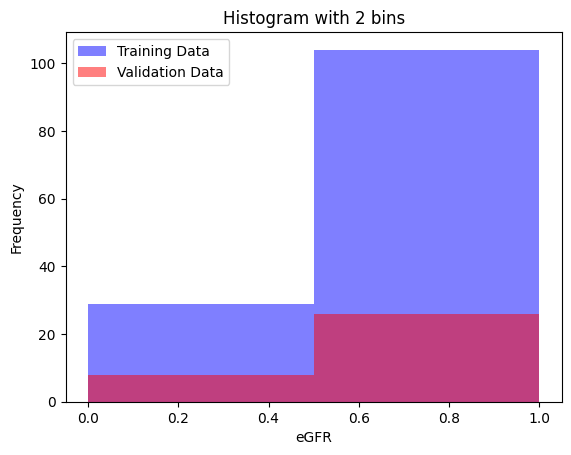

{0: np.float64(2.293103448275862), 1: np.float64(0.6394230769230769)}
Epoch 1/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.4598 - auc: 0.4915 - loss: 0.7460 - val_accuracy: 0.2500 - val_auc: 0.5352 - val_loss: 0.7354
Epoch 2/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5475 - auc: 0.5112 - loss: 0.7611 - val_accuracy: 0.2500 - val_auc: 0.6085 - val_loss: 0.7800
Epoch 3/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.5286 - auc: 0.5797 - loss: 0.7458 - val_accuracy: 0.2500 - val_auc: 0.6717 - val_loss: 0.8789
Epoch 4/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5899 - auc: 0.6207 - loss: 0.6957 - val_accuracy: 0.2500 - val_auc: 0.6379 - val_loss: 1.3181
Epoch 5/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5711 - auc: 0.5618 - loss: 0.7194 - val_accuracy: 0.3100 - val_auc: 0.6269 - val_loss: 1.1422
Epoch 6/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6065 - auc: 0.6387 - loss: 0.6947 - val_accuracy: 0.2900 - val

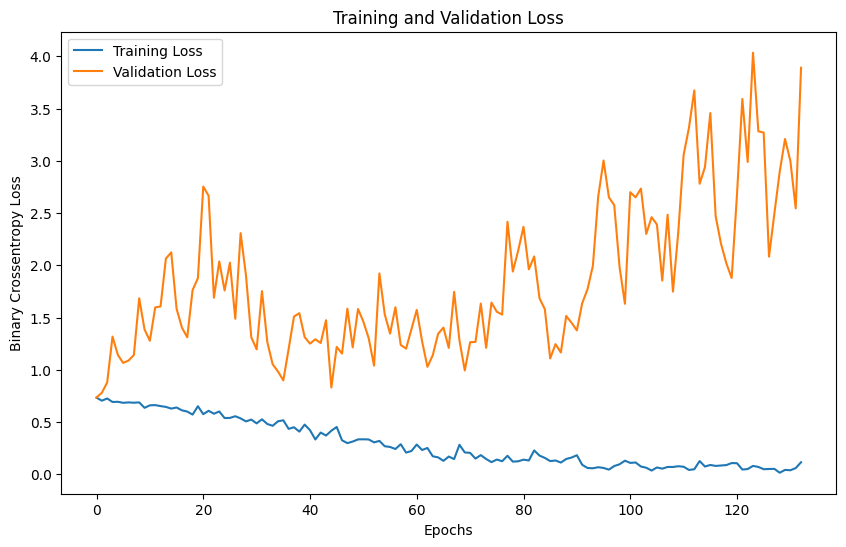

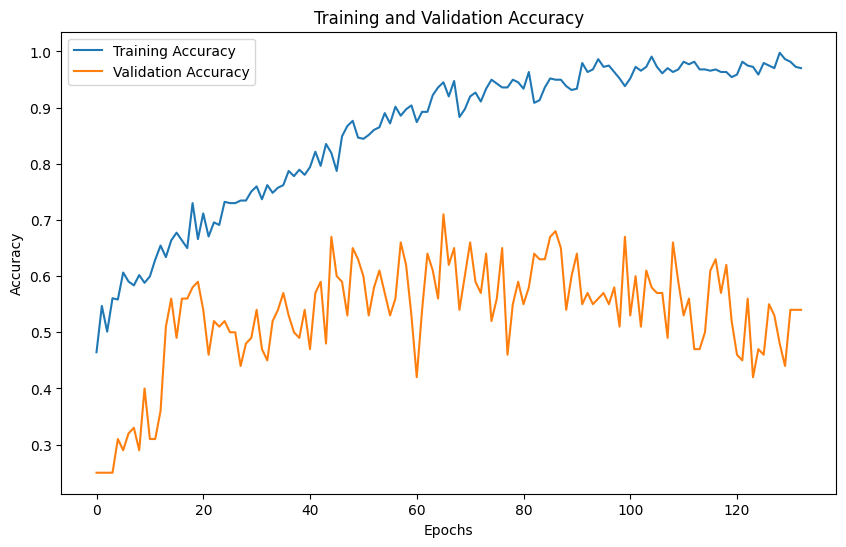

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━

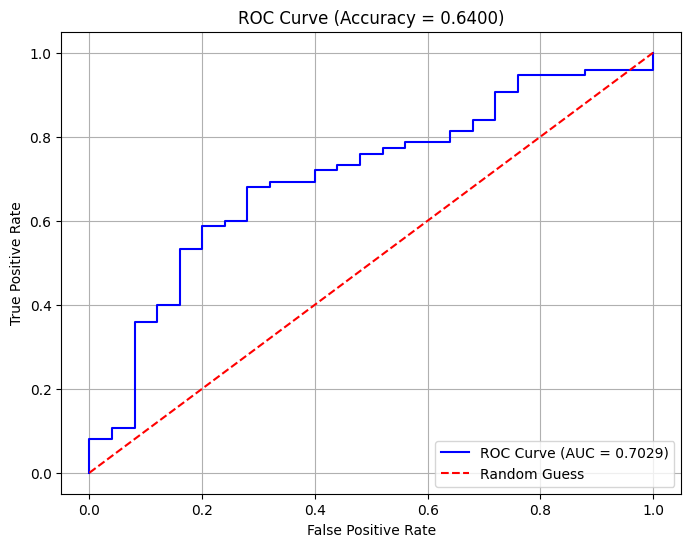

Accuracy for K-Fold 1: 0.6400
AUC for K-Fold 1: 0.7029
              precision    recall  f1-score   support

           0     0.3830    0.7200    0.5000        25
           1     0.8679    0.6133    0.7188        75

    accuracy                         0.6400       100
   macro avg     0.6255    0.6667    0.6094       100
weighted avg     0.7467    0.6400    0.6641       100

Fold 2


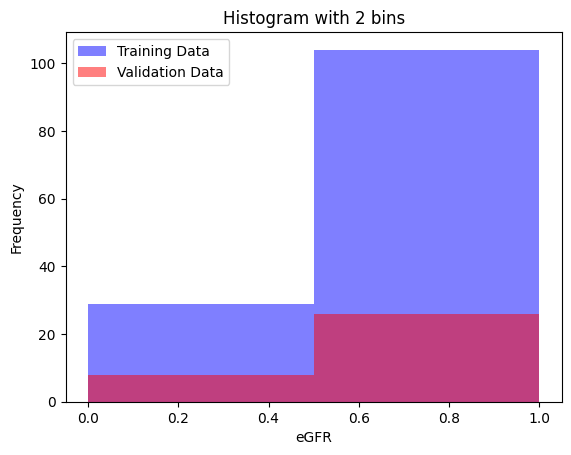

{0: np.float64(2.293103448275862), 1: np.float64(0.6394230769230769)}
Epoch 1/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5169 - auc: 0.4857 - loss: 0.7581 - val_accuracy: 0.2250 - val_auc: 0.4740 - val_loss: 0.7029
Epoch 2/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.4819 - auc: 0.5587 - loss: 0.7290 - val_accuracy: 0.2333 - val_auc: 0.4323 - val_loss: 0.7619
Epoch 3/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5145 - auc: 0.5122 - loss: 0.7535 - val_accuracy: 0.2167 - val_auc: 0.4610 - val_loss: 0.7653
Epoch 4/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5761 - auc: 0.6421 - loss: 0.6994 - val_accuracy: 0.3417 - val_auc: 0.4231 - val_loss: 0.7410
Epoch 5/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5043 - auc: 0.6048 - loss: 0.7153 - val_accuracy: 0.3333 - val_auc: 0.4154 - val_loss: 0.9033
Epoch 6/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5644 - auc: 0.5895 - loss: 0.7253 - val_accuracy: 0.5583 - val_a

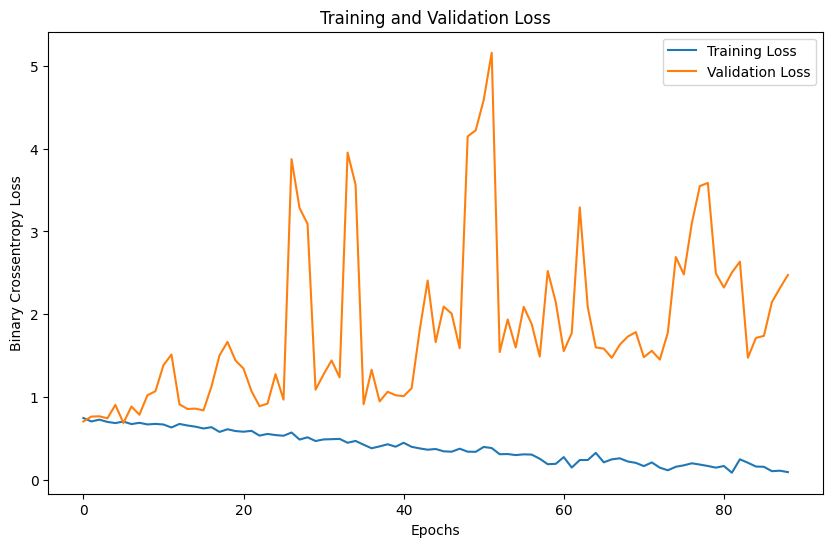

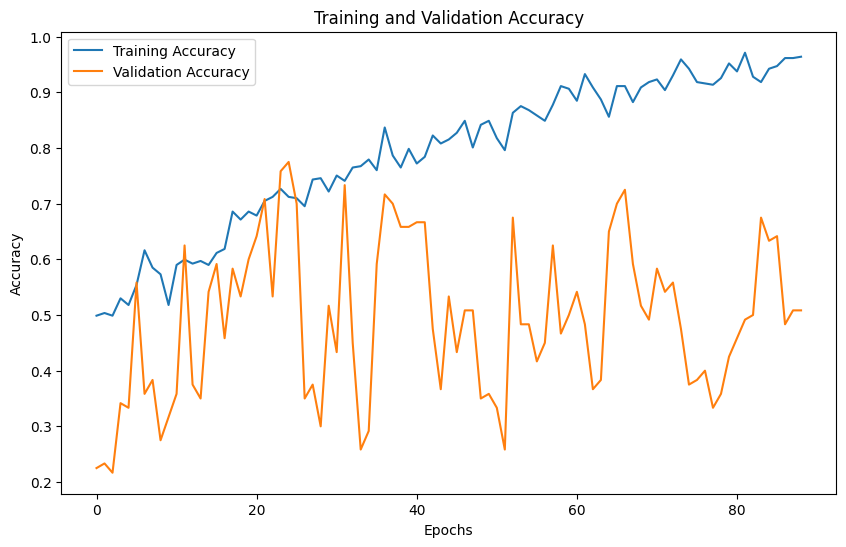

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

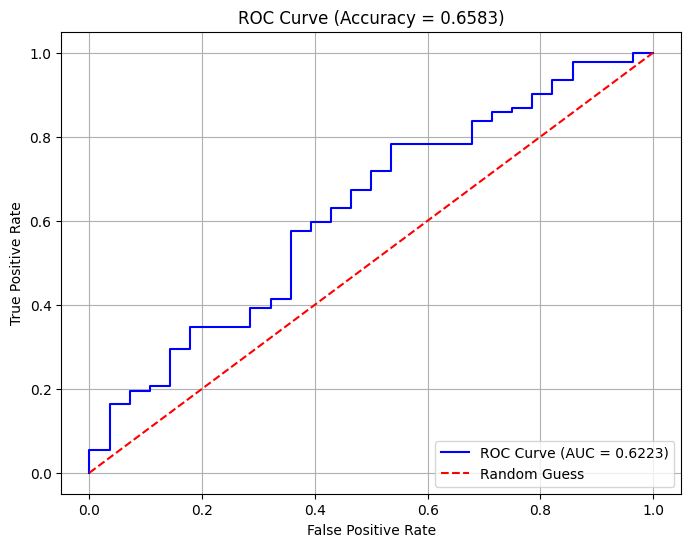

Accuracy for K-Fold 2: 0.6583
AUC for K-Fold 2: 0.6223
              precision    recall  f1-score   support

           0     0.3415    0.5000    0.4058        28
           1     0.8228    0.7065    0.7602        92

    accuracy                         0.6583       120
   macro avg     0.5821    0.6033    0.5830       120
weighted avg     0.7105    0.6583    0.6775       120

Fold 3


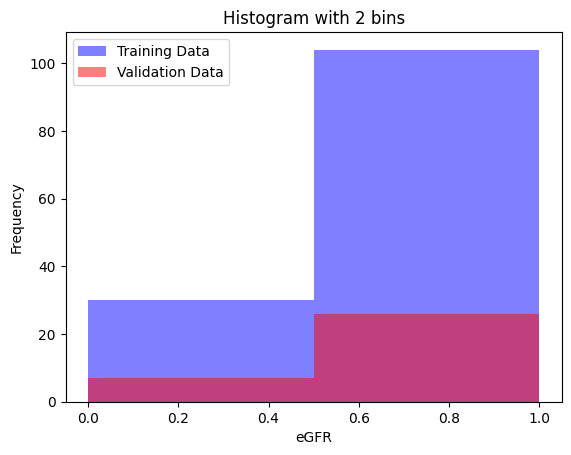

{0: np.float64(2.2333333333333334), 1: np.float64(0.6442307692307693)}
Epoch 1/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.5202 - auc: 0.5102 - loss: 0.7376 - val_accuracy: 0.2400 - val_auc: 0.4852 - val_loss: 0.7116
Epoch 2/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6229 - auc: 0.5018 - loss: 0.7445 - val_accuracy: 0.4800 - val_auc: 0.5992 - val_loss: 0.6951
Epoch 3/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5840 - auc: 0.5941 - loss: 0.7140 - val_accuracy: 0.4900 - val_auc: 0.6620 - val_loss: 0.6997
Epoch 4/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6030 - auc: 0.6206 - loss: 0.7018 - val_accuracy: 0.6700 - val_auc: 0.6661 - val_loss: 0.6293
Epoch 5/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5589 - auc: 0.5272 - loss: 0.7450 - val_accuracy: 0.5200 - val_auc: 0.7242 - val_loss: 0.6896
Epoch 6/160
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5854 - auc: 0.5819 - loss: 0.7133 - val_accuracy: 0.6800 - 

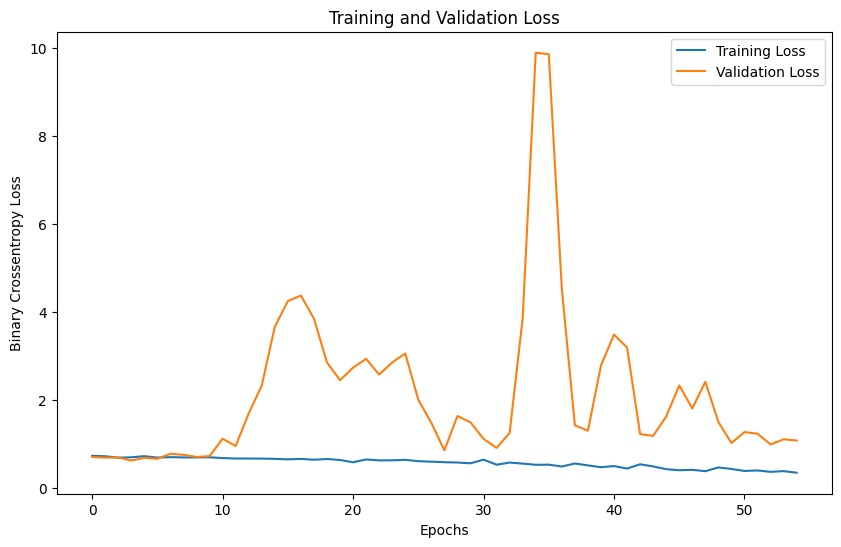

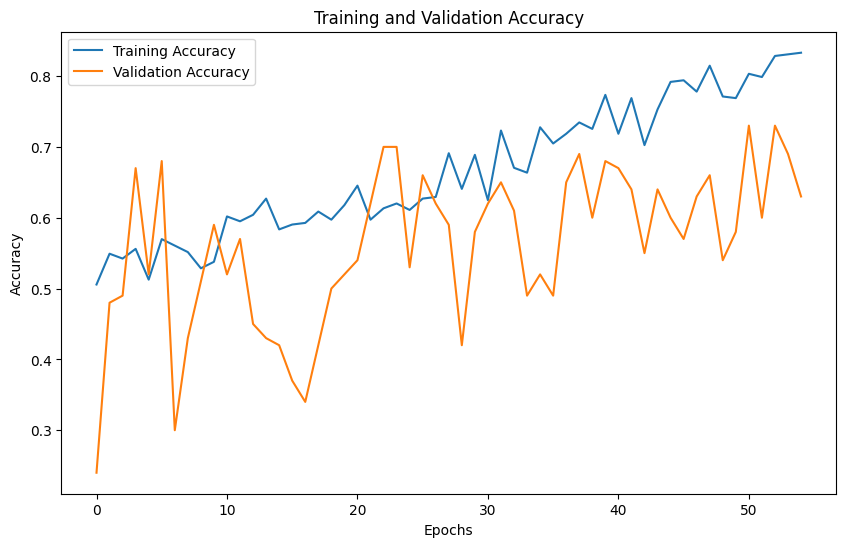

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━

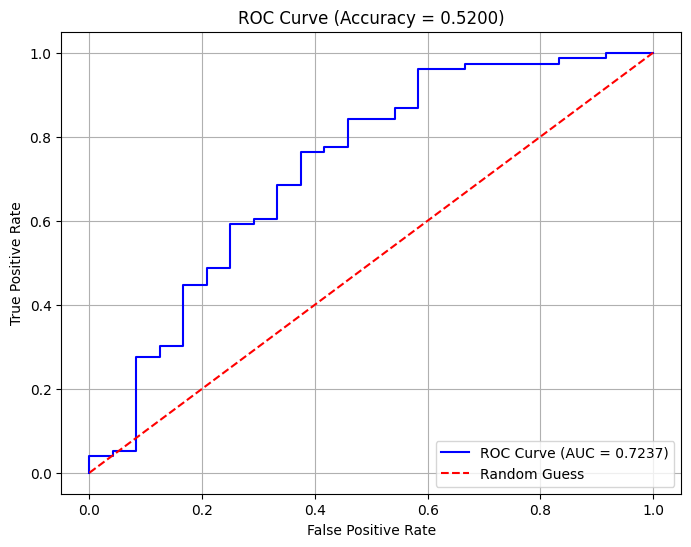

Accuracy for K-Fold 3: 0.5200
AUC for K-Fold 3: 0.7237
              precision    recall  f1-score   support

           0     0.3125    0.8333    0.4545        24
           1     0.8889    0.4211    0.5714        76

    accuracy                         0.5200       100
   macro avg     0.6007    0.6272    0.5130       100
weighted avg     0.7506    0.5200    0.5434       100

Fold 4


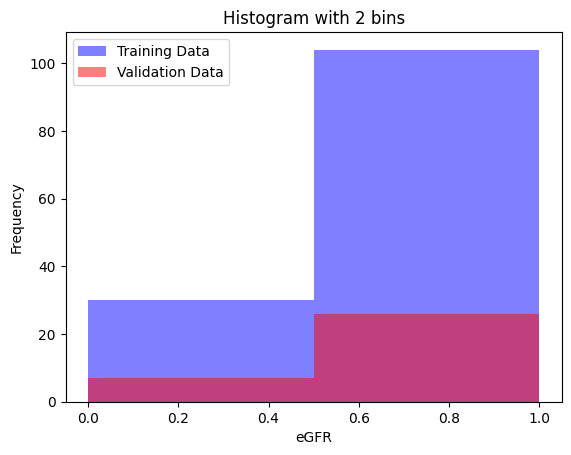

{0: np.float64(2.2333333333333334), 1: np.float64(0.6442307692307693)}
Epoch 1/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.4177 - auc: 0.4540 - loss: 0.7561 - val_accuracy: 0.1909 - val_auc: 0.5639 - val_loss: 0.7309
Epoch 2/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5339 - auc: 0.4967 - loss: 0.7591 - val_accuracy: 0.1909 - val_auc: 0.6196 - val_loss: 0.8028
Epoch 3/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5151 - auc: 0.5555 - loss: 0.7355 - val_accuracy: 0.1909 - val_auc: 0.5963 - val_loss: 0.8869
Epoch 4/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5608 - auc: 0.5958 - loss: 0.7166 - val_accuracy: 0.4000 - val_auc: 0.5404 - val_loss: 0.7480
Epoch 5/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5250 - auc: 0.4706 - loss: 0.7741 - val_accuracy: 0.3727 - val_auc: 0.5083 - val_loss: 1.0491
Epoch 6/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5941 - auc: 0.6265 - loss: 0.6969 - val_accuracy: 0.2727 - val

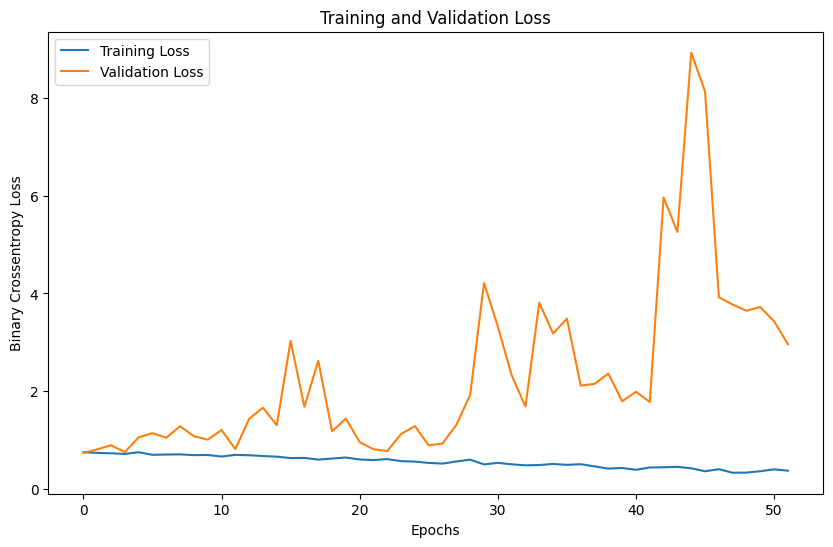

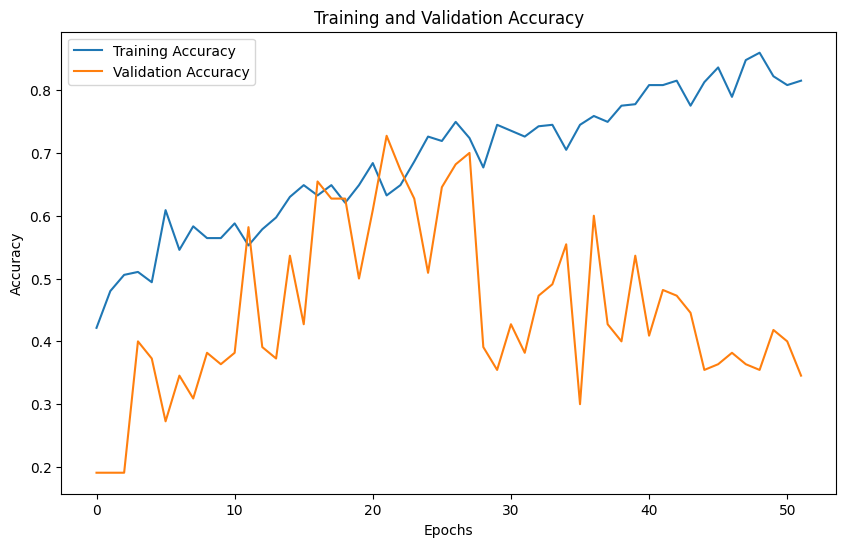

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━

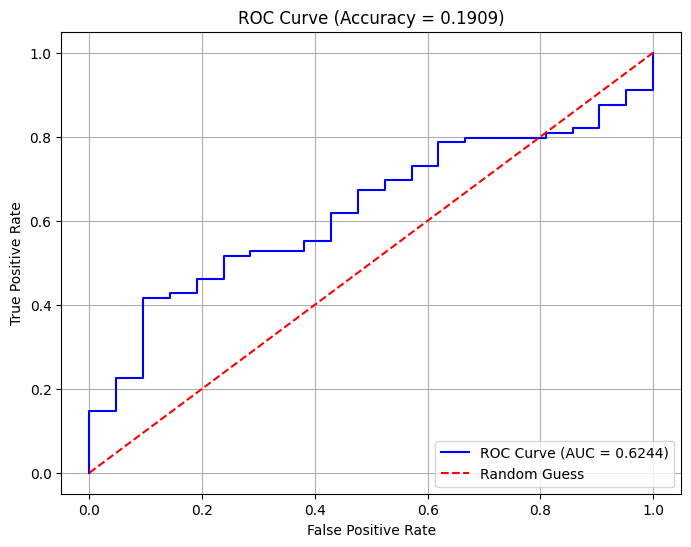

Accuracy for K-Fold 4: 0.1909
AUC for K-Fold 4: 0.6244
              precision    recall  f1-score   support

           0     0.1909    1.0000    0.3206        21
           1     0.0000    0.0000    0.0000        89

    accuracy                         0.1909       110
   macro avg     0.0955    0.5000    0.1603       110
weighted avg     0.0364    0.1909    0.0612       110

Fold 5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


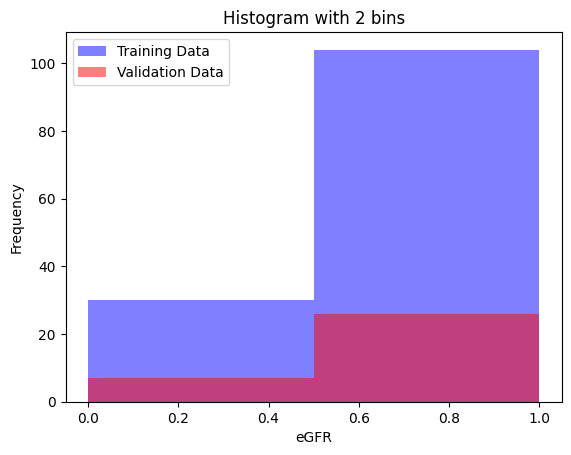

{0: np.float64(2.2333333333333334), 1: np.float64(0.6442307692307693)}
Epoch 1/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5778 - auc: 0.4766 - loss: 0.7878 - val_accuracy: 0.2336 - val_auc: 0.6410 - val_loss: 0.7321
Epoch 2/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5168 - auc: 0.4827 - loss: 0.7722 - val_accuracy: 0.5607 - val_auc: 0.5654 - val_loss: 0.6954
Epoch 3/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5661 - auc: 0.5687 - loss: 0.7364 - val_accuracy: 0.7570 - val_auc: 0.4259 - val_loss: 0.6326
Epoch 4/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.4968 - auc: 0.4874 - loss: 0.7752 - val_accuracy: 0.6729 - val_auc: 0.5290 - val_loss: 0.6708
Epoch 5/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5016 - auc: 0.4866 - loss: 0.7501 - val_accuracy: 0.7570 - val_auc: 0.4734 - val_loss: 0.5784
Epoch 6/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4799 - auc: 0.5308 - loss: 0.7495 - val_accuracy: 0.5888 - val_

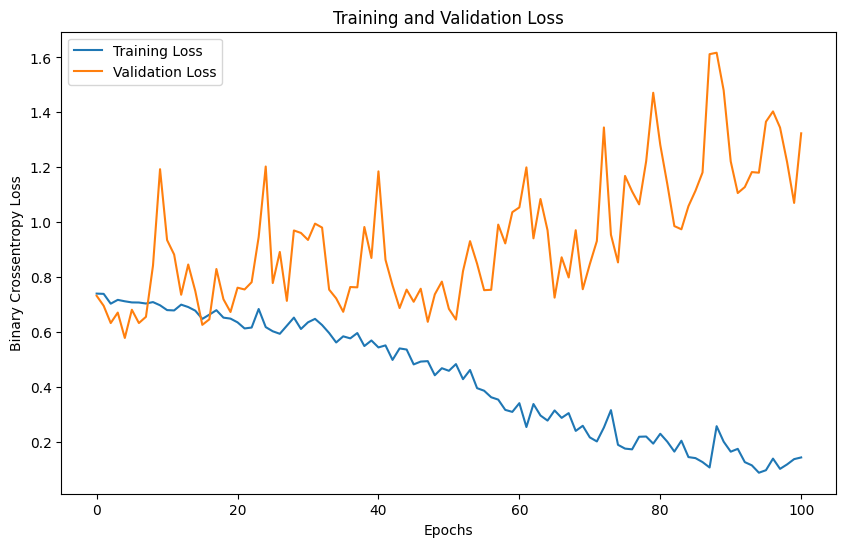

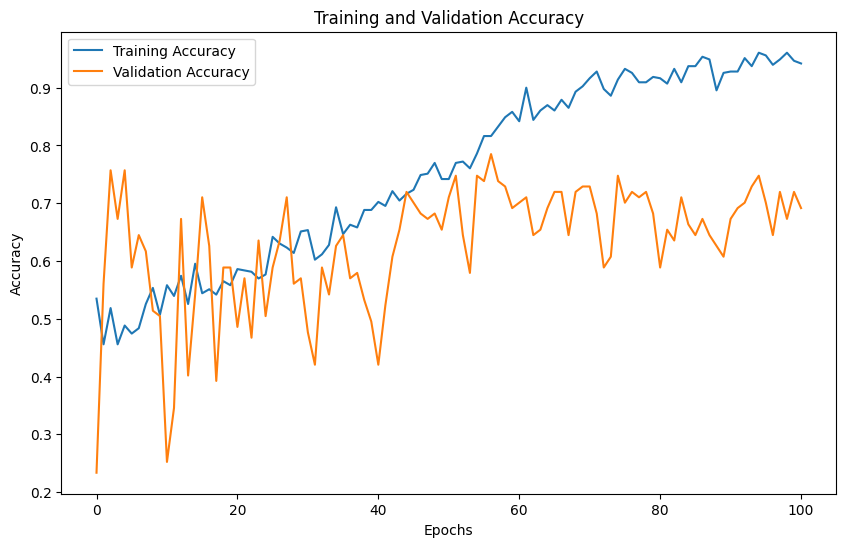

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

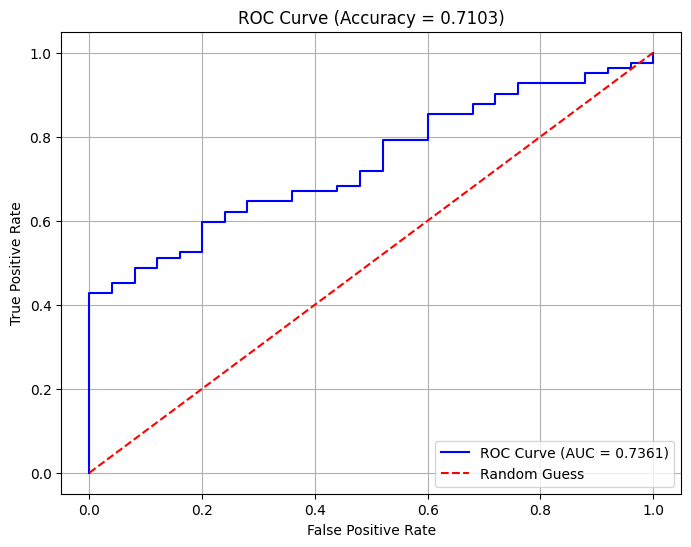

Accuracy for K-Fold 5: 0.7103
AUC for K-Fold 5: 0.7361
              precision    recall  f1-score   support

           0     0.3929    0.4400    0.4151        25
           1     0.8228    0.7927    0.8075        82

    accuracy                         0.7103       107
   macro avg     0.6078    0.6163    0.6113       107
weighted avg     0.7223    0.7103    0.7158       107

Average AUC for config resnet_with_tranfer_learning: 0.6819
Best config settings: resnet_with_tranfer_learning
-----------------
Training with the best config
-----------------


In [ ]:
all_patients = label_img_classification_by_patient(B_MODE_IMAGE_FOLDER, H_SCAN_IMAGE_FOLDER, CSV_FILE)

# Split patients into train/test
train_and_val_patients, test_patients = train_test_split(
    all_patients, test_size=0.1, random_state=SEED
)

# Do hyperparameter tuning
best_config = list(hyper_parameter_tuning_configs.keys())[0]
best_auc = 0

for config_name, model_creator in hyper_parameter_tuning_configs.items():
  # if len(hyper_parameter_tuning_configs.keys()) == 1:
  #   continue
  print(f"Training w\\ Config: {config_name}")

  # Do stratified k-folding based on eGFR
  all_patient_egfr = [patient.egfr for patient in train_and_val_patients]

  # Save model performance (mse) across k-folds
  k_fold_performances = []

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
  for fold, (train_idx, val_idx) in enumerate(skf.split(train_and_val_patients, all_patient_egfr)):
    print(f"Fold {fold + 1}")

    train_patients = [train_and_val_patients[i] for i in train_idx]
    val_patients = [train_and_val_patients[i] for i in val_idx]

    plotHistogramOfDataset([patient.egfr for patient in train_patients], [patient.egfr for patient in val_patients], 2)

    # Create dataset for this fold
    train_dataset_fold = create_dataset_from_patients(train_patients, augment=True, batch_size=BATCH_SIZE)
    val_dataset = create_dataset_from_patients(val_patients, augment=False, batch_size=BATCH_SIZE)

    # Compute class weights
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.array([patient.egfr for patient in train_patients]).astype(int)),
        y=np.array([patient.egfr for patient in train_patients]).astype(int)
    )
    class_weights_dict = dict(enumerate(weights))
    print(class_weights_dict)

    model = model_creator()

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', mode='max', patience=50, restore_best_weights=True
    )

    history = model.fit(
        train_dataset_fold,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        class_weight=class_weights_dict
    )

    plotTrainingHistory(history)

    patient_to_true_labels, patient_to_predicted_probs = plotAndReturnValidationTesting(val_patients, model)

    true_labels = []
    predicted_probs = []
    for patient_id in patient_to_predicted_probs:
        for prob in patient_to_predicted_probs[patient_id]:
            true_labels.append(patient_to_true_labels[patient_id])
            predicted_probs.append(prob)

    predicted_labels = [1 if p >= 0.5 else 0 for p in predicted_probs]

    accuracy = accuracy_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_probs)

    print(f"Accuracy for K-Fold {fold + 1}: {accuracy:.4f}")
    print(f"AUC for K-Fold {fold + 1}: {auc:.4f}")
    print(classification_report(true_labels, predicted_labels, digits=4))

    # Save model performance
    k_fold_performances.append(auc)

  average_auc = np.mean(k_fold_performances)
  print(f"Average AUC for config {config_name}: {average_auc:.4f}")

  if average_auc > best_auc:
    best_auc = average_auc
    best_config = config_name

print(f"Best config settings: {best_config}")

print("-----------------")
print("Training with the best config")
print("-----------------")

# Retrain perfect model with entire train/val dataset and do final prediction on test dataset
train_and_val_dataset = create_dataset_from_patients(train_and_val_patients, augment=True, batch_size=BATCH_SIZE)
test_dataset = create_dataset_from_patients(test_patients, augment=False, batch_size=BATCH_SIZE)

best_config_creator = hyper_parameter_tuning_configs[best_config]
model = best_config_creator()

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.array([patient.egfr for patient in train_and_val_patients]).astype(int)),
    y=np.array([patient.egfr for patient in train_and_val_patients]).astype(int)
)
class_weights_dict = dict(enumerate(weights))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=50, restore_best_weights=True
)

history = model.fit(
    train_and_val_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

plotTrainingHistory(history)

patient_to_true_labels, patient_to_predicted_probs = plotAndReturnValidationTesting(test_patients, model)

true_labels = []
predicted_probs = []
for patient_id in patient_to_predicted_probs:
    for prob in patient_to_predicted_probs[patient_id]:
        true_labels.append(patient_to_true_labels[patient_id])
        predicted_probs.append(prob)

predicted_labels = [1 if p >= 0.5 else 0 for p in predicted_probs]

accuracy = accuracy_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_probs)

print(f"\nFinal Test Accuracy: {accuracy:.4f}")
print(f"Final Test AUC: {auc:.4f}")
print("\nFinal Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.utils import class_weight
import numpy as np

# -------------------------
# Model definition
# -------------------------
def build_dense_only_hscan_model():
    """
    Builds a simple neural net that takes only H-scan input (grayscale),
    flattens the image, and uses dense layers for binary classification.
    """
    input_hscan = Input(shape=(224, 224, 1), name="hscan_input")

    x = layers.Flatten()(input_hscan)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_hscan, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='val_auc')]
    )
    return model

# -------------------------
# Dataset preprocessing
# -------------------------
def preprocess_hscan_image(file_path, label):
    """
    Reads an H-scan image, converts to grayscale, resizes to 224x224, normalizes to [0,1]
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)   # Decode as single channel (H, W, 1)
    img = tf.image.resize(img, [224, 224])        # Resize to 224x224
    img = tf.cast(img, tf.float32) / 255.0        # Normalize to [0,1]
    return img, label

def create_dataset_from_patients(patients, augment=False, batch_size=32):
    image_paths = []
    labels = []

    for p in patients:
        for img_path in p.hscan_images:  # Assuming each patient has a list of H-scan image paths
            image_paths.append(img_path)
            labels.append(p.label)       # Binary label

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(preprocess_hscan_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        # Example augmentation
        ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# -------------------------
# Config dictionary
# -------------------------
hyper_parameter_tuning_configs = {
    "dense_only_hscan": build_dense_only_hscan_model
}

# -------------------------
# Load and split patients
# -------------------------
all_patients = label_img_classification_by_patient(B_MODE_IMAGE_FOLDER, H_SCAN_IMAGE_FOLDER, CSV_FILE)

train_and_val_patients, test_patients = train_test_split(
    all_patients, test_size=0.1, random_state=SEED
)

# -------------------------
# Hyperparameter tuning with stratified K-Fold
# -------------------------
best_config = list(hyper_parameter_tuning_configs.keys())[0]
best_auc = 0

for config_name, model_creator in hyper_parameter_tuning_configs.items():
    print(f"Training w/ Config: {config_name}")

    all_patient_egfr = [p.egfr for p in train_and_val_patients]
    k_fold_performances = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_and_val_patients, all_patient_egfr)):
        print(f"Fold {fold + 1}")

        train_patients = [train_and_val_patients[i] for i in train_idx]
        val_patients = [train_and_val_patients[i] for i in val_idx]

        plotHistogramOfDataset([p.egfr for p in train_patients], [p.egfr for p in val_patients], 2)

        train_dataset_fold = create_dataset_from_patients_hscan_only(train_patients, augment=True, batch_size=BATCH_SIZE)
        val_dataset = create_dataset_from_patients_hscan_only(val_patients, augment=False, batch_size=BATCH_SIZE)

        weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(np.array([p.egfr for p in train_patients]).astype(int)),
            y=np.array([p.egfr for p in train_patients]).astype(int)
        )
        class_weights_dict = dict(enumerate(weights))
        print(class_weights_dict)

        model = model_creator()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_auc', mode='max', patience=50, restore_best_weights=True
        )

        history = model.fit(
            train_dataset_fold,
            validation_data=val_dataset,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            class_weight=class_weights_dict
        )

        plotTrainingHistory(history)

        patient_to_true_labels, patient_to_predicted_probs = plotAndReturnValidationTesting(val_patients, model)

        true_labels, predicted_probs = [], []
        for pid in patient_to_predicted_probs:
            for prob in patient_to_predicted_probs[pid]:
                true_labels.append(patient_to_true_labels[pid])
                predicted_probs.append(prob)

        predicted_labels = [1 if p >= 0.5 else 0 for p in predicted_probs]

        accuracy = accuracy_score(true_labels, predicted_labels)
        auc = roc_auc_score(true_labels, predicted_probs)

        print(f"Accuracy for K-Fold {fold + 1}: {accuracy:.4f}")
        print(f"AUC for K-Fold {fold + 1}: {auc:.4f}")
        print(classification_report(true_labels, predicted_labels, digits=4))

        k_fold_performances.append(auc)

    average_auc = np.mean(k_fold_performances)
    print(f"Average AUC for config {config_name}: {average_auc:.4f}")

    if average_auc > best_auc:
        best_auc = average_auc
        best_config = config_name

print(f"Best config settings: {best_config}")

# -------------------------
# Retrain with best config on all train/val patients
# -------------------------
print("-----------------")
print("Training with the best config")
print("-----------------")

train_and_val_dataset = create_dataset_from_patients_hscan_only(train_and_val_patients, augment=False, batch_size=BATCH_SIZE)
test_dataset = create_dataset_from_patients_hscan_only(test_patients, augment=False, batch_size=BATCH_SIZE)

best_config_creator = hyper_parameter_tuning_configs[best_config]
model = best_config_creator()

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.array([p.egfr for p in train_and_val_patients]).astype(int)),
    y=np.array([p.egfr for p in train_and_val_patients]).astype(int)
)
class_weights_dict = dict(enumerate(weights))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=50, restore_best_weights=True
)

history = model.fit(
    train_and_val_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

plotTrainingHistory(history)

patient_to_true_labels, patient_to_predicted_probs = plotAndReturnValidationTesting(test_patients, model)

true_labels, predicted_probs = [], []
for pid in patient_to_predicted_probs:
    for prob in patient_to_predicted_probs[pid]:
        true_labels.append(patient_to_true_labels[pid])
        predicted_probs.append(prob)

predicted_labels = [1 if p >= 0.5 else 0 for p in predicted_probs]

accuracy = accuracy_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_probs)

print(f"\nFinal Test Accuracy: {accuracy:.4f}")
print(f"Final Test AUC: {auc:.4f}")
print("\nFinal Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))

Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128

NameError: name 'plotHistogramOfDataset' is not defined

Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 102 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 114 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 11 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 120 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 126 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128 not found in CSV, skipping...
Patient ID 128

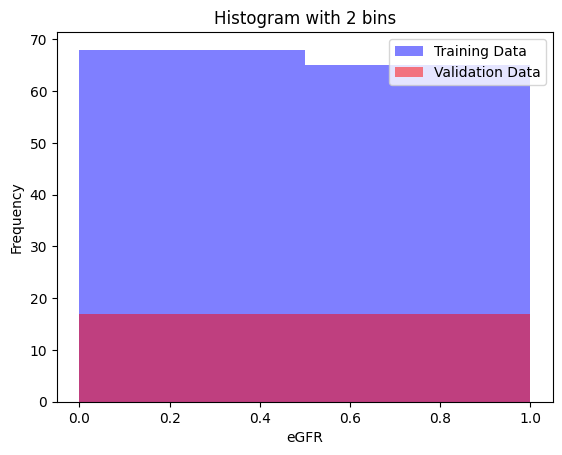

Epoch 1/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5526 - auc: 0.5355 - loss: 0.6939 - val_accuracy: 0.5688 - val_auc: 0.4470 - val_loss: 0.6901 - learning_rate: 1.0000e-04
Epoch 2/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5375 - auc: 0.5684 - loss: 0.6819 - val_accuracy: 0.5688 - val_auc: 0.5103 - val_loss: 0.6854 - learning_rate: 1.0000e-04
Epoch 3/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5560 - auc: 0.6038 - loss: 0.6726 - val_accuracy: 0.5688 - val_auc: 0.5225 - val_loss: 0.6848 - learning_rate: 1.0000e-04
Epoch 4/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5385 - auc: 0.6000 - loss: 0.6754 - val_accuracy: 0.5688 - val_auc: 0.4876 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 5/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6200 - auc: 0.6490 - loss: 0.6571 - val_accuracy: 0.5688 - val_auc: 0.5671 - val_loss: 0.7439 - learning_rate: 1.0000e-04
Epoch 6/160
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accurac

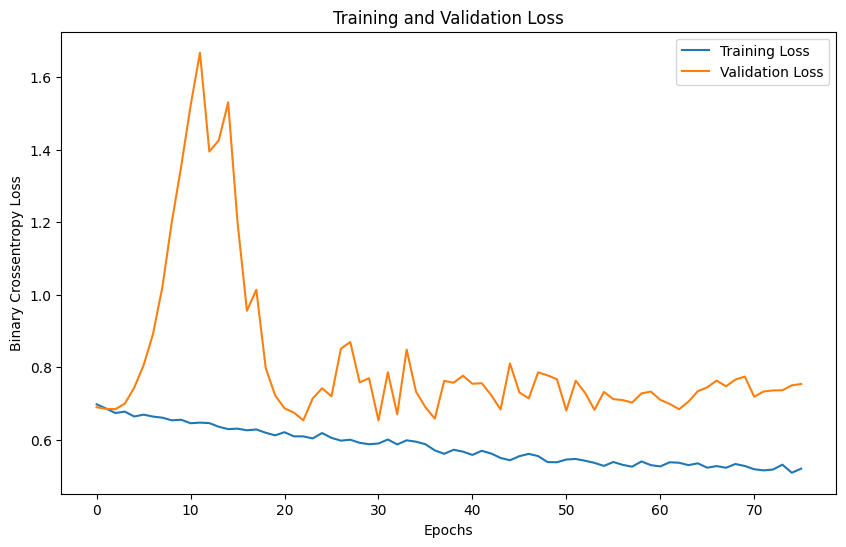

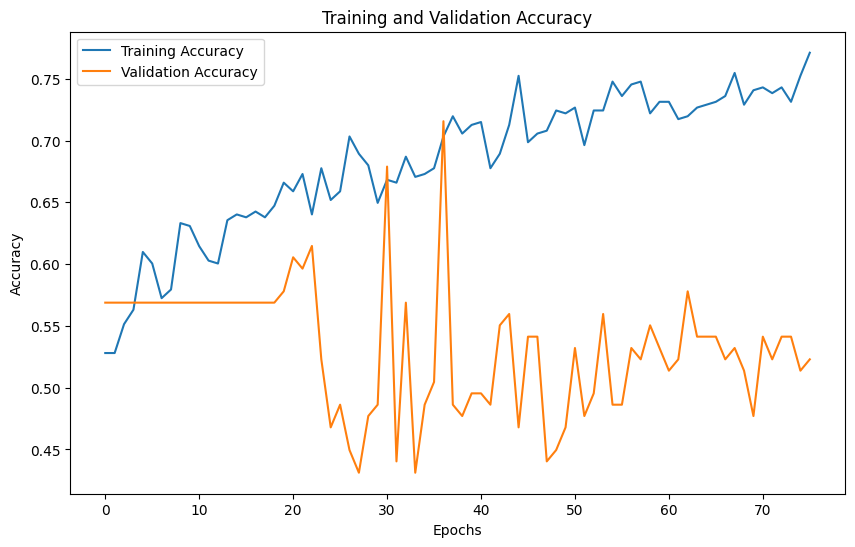

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import tensorflow as tf

# ---------------------------------------------------
# Step 1: Load patients and split into train/val vs test
# ---------------------------------------------------
all_patients = label_img_classification_by_patient(
    B_MODE_IMAGE_FOLDER, H_SCAN_IMAGE_FOLDER, CSV_FILE
)

train_and_val_patients, test_patients = train_test_split(
    all_patients, test_size=0.1, random_state=SEED
)

# ---------------------------------------------------
# Step 2: Hyperparameter tuning with stratified k-fold CV
# ---------------------------------------------------
for config_name, model_creator in hyper_parameter_tuning_configs.items():
    print(f"\n==============================")
    print(f"Training with Config: {config_name}")
    print(f"==============================")

    all_patient_egfr = [patient.egfr for patient in train_and_val_patients]

    val_fold_aucs = []
    test_fold_aucs = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_and_val_patients, all_patient_egfr)):
        print(f"\n----- Fold {fold + 1} -----")

        train_patients = [train_and_val_patients[i] for i in train_idx]
        val_patients = [train_and_val_patients[i] for i in val_idx]

        # Plot distribution
        plotHistogramOfDataset(
            [patient.egfr for patient in train_patients],
            [patient.egfr for patient in val_patients],
            2
        )

        # Create datasets (two-input version)
        train_dataset_fold = create_dataset_from_patients(
            train_patients, augment=True, batch_size=BATCH_SIZE
        )
        val_dataset = create_dataset_from_patients(
            val_patients, augment=False, batch_size=BATCH_SIZE
        )
        test_dataset = create_dataset_from_patients(
            test_patients, augment=False, batch_size=BATCH_SIZE
        )

        # Compute class weights
        weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(np.array([patient.egfr for patient in train_patients]).astype(int)),
            y=np.array([patient.egfr for patient in train_patients]).astype(int)
        )
        class_weights_dict = dict(enumerate(weights))

        # Build model
        model = model_creator()

        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_auc', mode='max', patience=50, restore_best_weights=False
        )

        # Reduce LR on Plateau
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',   # track validation AUC
            mode='max',          # maximize AUC
            factor=0.5,          # reduce LR by half
            patience=10,         # wait 10 epochs with no improvement
            min_lr=1e-7,         # never go below this LR
            verbose=1
        )

        # Train
        history = model.fit(
            train_dataset_fold,
            validation_data=val_dataset,
            epochs=EPOCHS,
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weights_dict,
            verbose=1
        )

        plotTrainingHistory(history)

        # -------------------------
        # Validation performance
        # -------------------------
        patient_to_true_labels, patient_to_predicted_probs = plotAndReturnValidationTesting(val_patients, model)

        true_labels, predicted_probs = [], []
        for patient_id in patient_to_predicted_probs:
            for prob in patient_to_predicted_probs[patient_id]:
                true_labels.append(patient_to_true_labels[patient_id])
                predicted_probs.append(prob)

        predicted_labels = [1 if p >= 0.5 else 0 for p in predicted_probs]
        val_auc = roc_auc_score(true_labels, predicted_probs)
        print(f"Validation AUC (Fold {fold + 1}): {val_auc:.4f}")
        print(classification_report(true_labels, predicted_labels, digits=4))
        val_fold_aucs.append(val_auc)

        # Save best model for fold
        model.save_weights(f"best_model_fold_{fold+1}_{config_name}.weights.h5")

        # -------------------------
        # Test performance (same fold model)
        # -------------------------
        patient_to_true_labels, patient_to_predicted_probs = plotAndReturnValidationTesting(test_patients, model)

        true_labels, predicted_probs = [], []
        for patient_id in patient_to_predicted_probs:
            for prob in patient_to_predicted_probs[patient_id]:
                true_labels.append(patient_to_true_labels[patient_id])
                predicted_probs.append(prob)

        predicted_labels = [1 if p >= 0.5 else 0 for p in predicted_probs]
        test_auc = roc_auc_score(true_labels, predicted_probs)
        print(f"Test AUC (Fold {fold + 1}): {test_auc:.4f}")
        print(classification_report(true_labels, predicted_labels, digits=4))
        test_fold_aucs.append(test_auc)

    # ---------------------------------------------------
    # Final summary for this config
    # ---------------------------------------------------
    print(f"\n==== Final Results for Config: {config_name} ====")
    print(f"Mean Validation AUC: {np.mean(val_fold_aucs):.4f} ± {np.std(val_fold_aucs):.4f}")
    print(f"Mean Test AUC:       {np.mean(test_fold_aucs):.4f} ± {np.std(test_fold_aucs):.4f}")
    print("=================================================\n")


for visualization

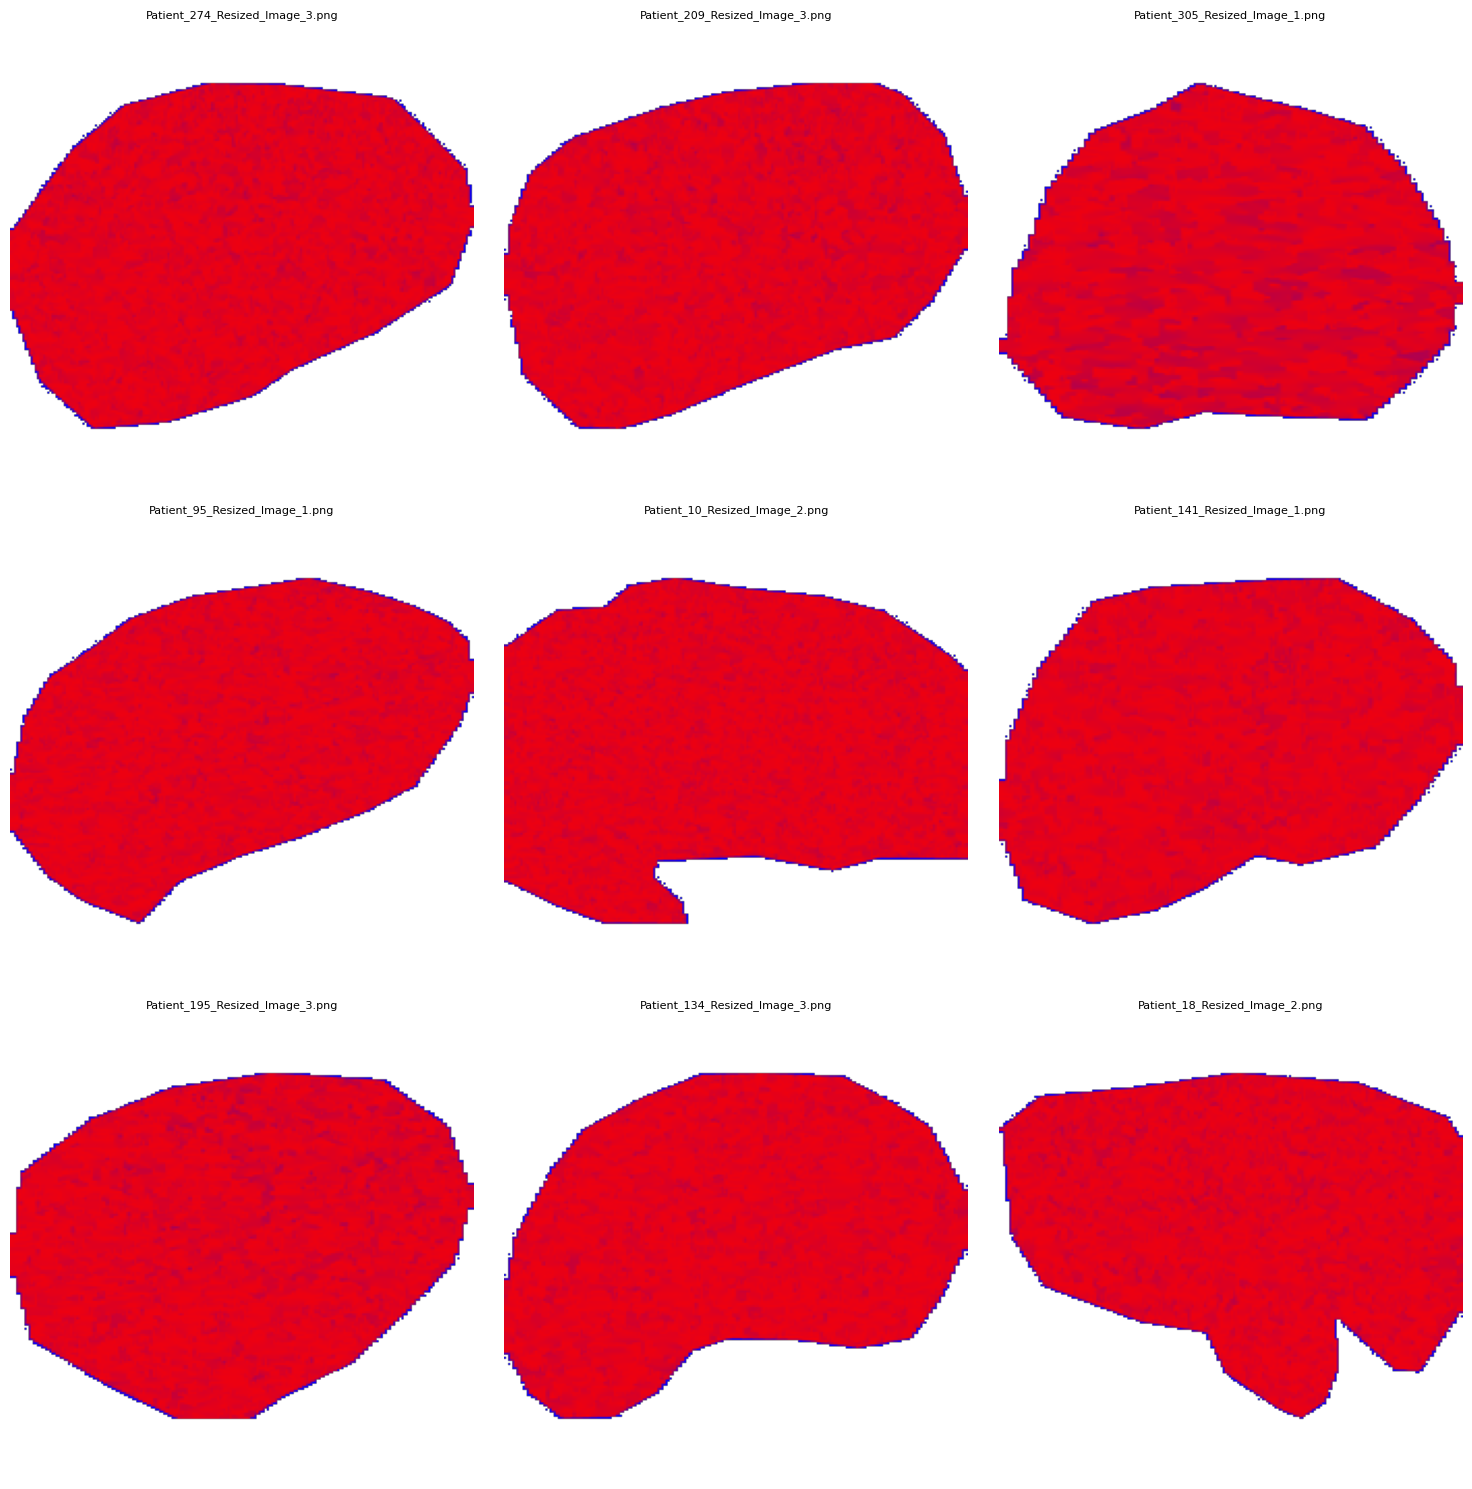

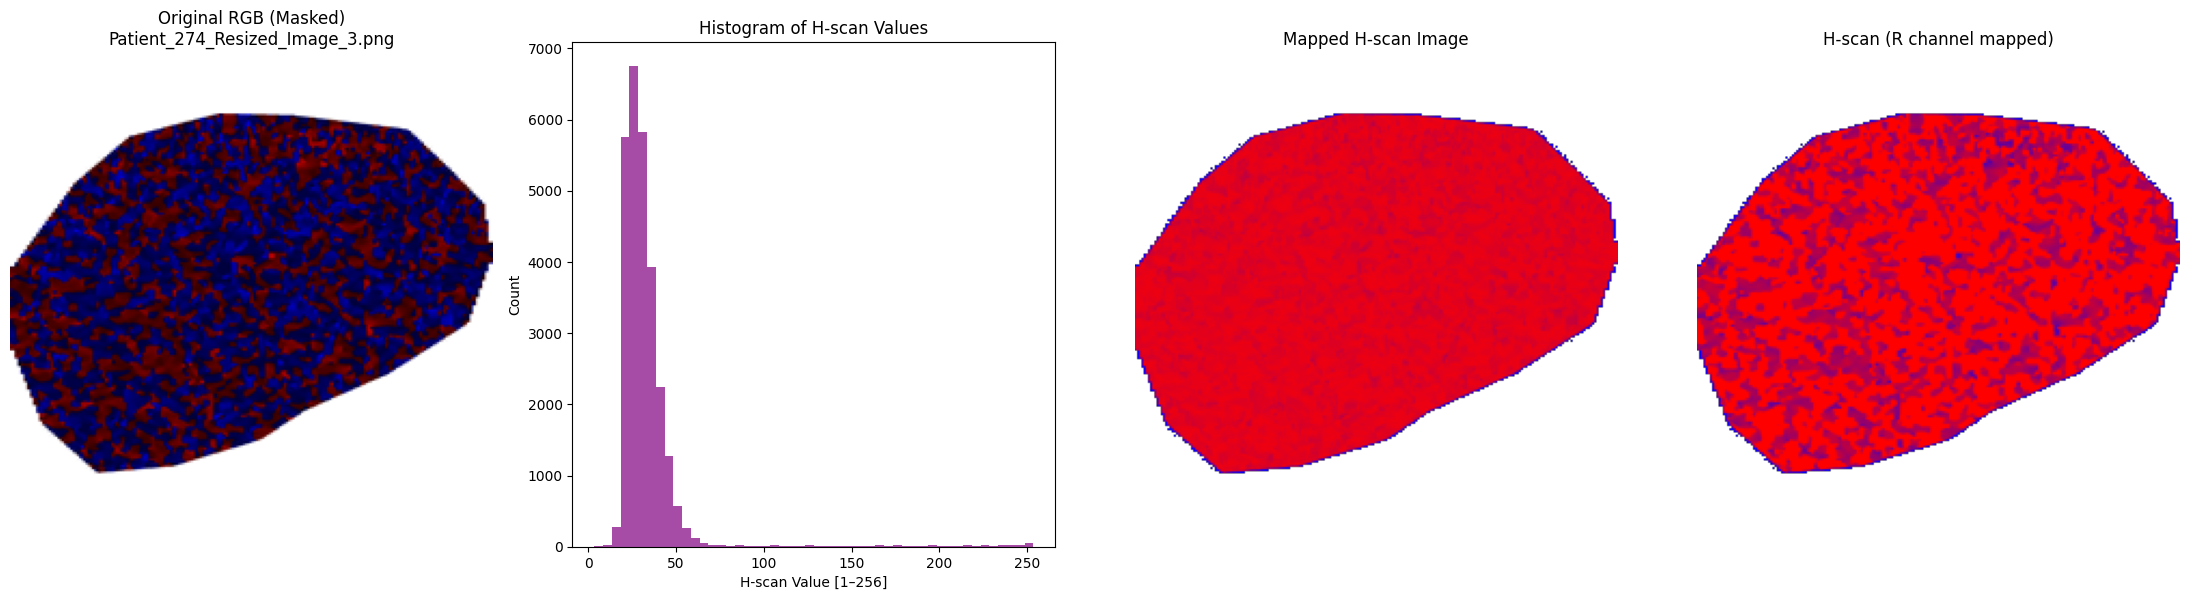

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import math
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# -------------------------
# Parameters
# -------------------------
H_SCAN_IMAGE_FOLDER = '/content/drive/MyDrive/uttiya_test_lab/hscan_resized_images'
NUM_IMAGES_TO_SHOW = 9    # number of images to visualize in grid
WHITE_THRESHOLD = 250      # anything >= this is considered background (white)

# -------------------------
# Preprocessing function
# -------------------------
def preprocess_hscan_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)   # RGB
    return img

# -------------------------
# Mapping function: pixel [0–255] → H-scan [1–256]
# -------------------------
def pixel_to_hscan(img):
    return 1 + (img.astype(np.float32) / 255.0) * (256 - 1)

# -------------------------
# Custom colormap: red (1) → blue (256)
# -------------------------
hscan_cmap = LinearSegmentedColormap.from_list("hscan_cmap", ["red", "blue"])

# -------------------------
# Collect image paths
# -------------------------
image_paths = [os.path.join(H_SCAN_IMAGE_FOLDER, f)
               for f in os.listdir(H_SCAN_IMAGE_FOLDER)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Pick random sample
sample_paths = random.sample(image_paths, min(NUM_IMAGES_TO_SHOW, len(image_paths)))
n_images = len(sample_paths)

# -------------------------
# Show sample masked + mapped H-scan images
# -------------------------
n_cols = 3
n_rows = math.ceil(n_images / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, path in enumerate(sample_paths):
    img = preprocess_hscan_image(path)
    img = img.numpy().astype(np.uint8)  # (H, W, 3)

    # Mask out white background
    mask_nonwhite = np.any(img < WHITE_THRESHOLD, axis=-1)
    masked_img = img.copy()
    masked_img[~mask_nonwhite] = 255

    # Convert grayscale proxy → H-scan values
    gray_img = np.mean(masked_img, axis=-1)  # simple average RGB → grayscale
    hscan_img = pixel_to_hscan(gray_img)

    # Mask background in H-scan too
    hscan_img[~mask_nonwhite] = np.nan

    axes[i].imshow(hscan_img, cmap=hscan_cmap, vmin=1, vmax=256)
    axes[i].set_title(os.path.basename(path), fontsize=8)
    axes[i].axis("off")

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# -------------------------
# Detailed analysis for ONE image
# -------------------------
one_path = sample_paths[0]
img = preprocess_hscan_image(one_path)
img = img.numpy().astype(np.uint8)  # RGB (H, W, 3)

mask_nonwhite = np.any(img < WHITE_THRESHOLD, axis=-1)

# Convert RGB → grayscale → H-scan values
gray_img = np.mean(img, axis=-1)
hscan_img = pixel_to_hscan(gray_img)
hscan_img[~mask_nonwhite] = np.nan

fig, axes = plt.subplots(1, 4, figsize=(22, 6))

# Original masked RGB
masked_img = img.copy()
masked_img[~mask_nonwhite] = 255
axes[0].imshow(masked_img)
axes[0].set_title(f"Original RGB (Masked)\n{os.path.basename(one_path)}")
axes[0].axis("off")

# Histogram of H-scan values
axes[1].hist(hscan_img[mask_nonwhite].flatten(), bins=50, color="purple", alpha=0.7)
axes[1].set_title("Histogram of H-scan Values")
axes[1].set_xlabel("H-scan Value [1–256]")
axes[1].set_ylabel("Count")

# H-scan colormap visualization
axes[2].imshow(hscan_img, cmap=hscan_cmap, vmin=1, vmax=256)
axes[2].set_title("Mapped H-scan Image")
axes[2].axis("off")

# Per-channel mapping (example: R only)
r_channel = pixel_to_hscan(img[..., 0])
r_channel[~mask_nonwhite] = np.nan
axes[3].imshow(r_channel, cmap=hscan_cmap, vmin=1, vmax=256)
axes[3].set_title("H-scan (R channel mapped)")
axes[3].axis("off")

plt.tight_layout()
plt.show()


# Save Model to File

In [ ]:
model_name = 'resnet_radimagenet_no_masking_lr0001__1346596590793527366'
# Please do not set to true accidently, to ensure models to not get erased
overwrite = False
model.save('/content/drive/MyDrive/uttiya_test_lab/model_weights/' + model_name + '.keras', overwrite=overwrite)

# Load model and show performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


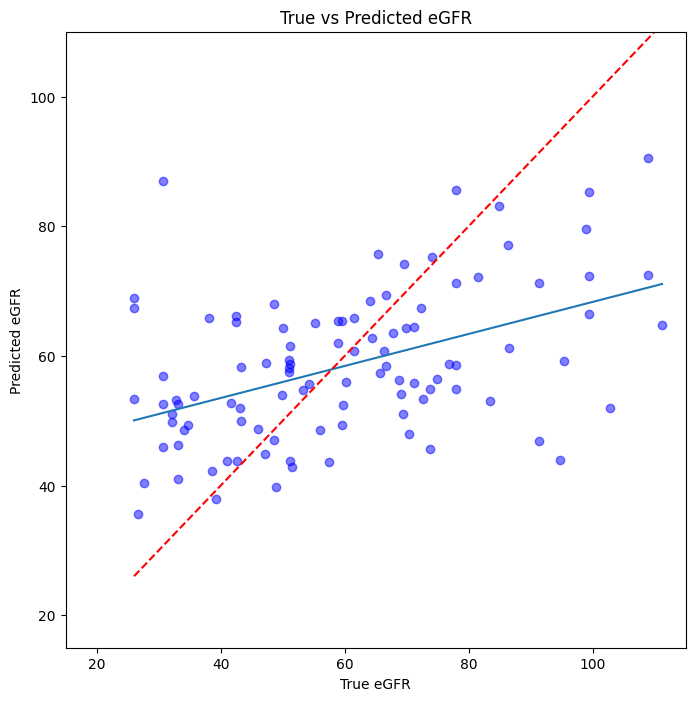

Correlation between True and Predicted eGFR: 0.47
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 395.2542 - mae: 15.4926
Test Loss: 373.3247985839844, Test MAE: 14.888872146606445
Mean Absolute Error (MAE): 14.89
Root Mean Squared Error (RMSE): 19.32
R² Score: 0.21


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/uttiya_test_lab/model_weights/' + model_name + '.keras')

# Predict on the test set
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(labels.numpy().flatten())
    predicted_labels.extend(preds.flatten())



# Plot True vs Predicted eGFR
plt.figure(figsize=(8, 8))
plt.scatter(true_labels, predicted_labels, c='blue', alpha=0.5)
# Draw line of best fit for the prediction (to show trend)
plt.plot(np.unique(true_labels), np.poly1d(np.polyfit(true_labels, predicted_labels, 1))(np.unique(true_labels)))

plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--')  # Perfect prediction line
plt.xlabel('True eGFR')
# Set scale to be 20-100
plt.xlim(15, 115)
plt.ylim(15, 110)
plt.ylabel('Predicted eGFR')
plt.title('True vs Predicted eGFR')
plt.show()

correlation = np.corrcoef(true_labels, predicted_labels)[0, 1]
print(f"Correlation between True and Predicted eGFR: {correlation:.2f}")


# Evaluate
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

# Compute metrics
mae = mean_absolute_error(true_labels, predicted_labels)
rmse = np.sqrt(mean_squared_error(true_labels, predicted_labels))
r2 = r2_score(true_labels, predicted_labels)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Display Feature Maps

In [ ]:
# Show feature maps of conv layers

for layer in model.layers[1].layers:
  # print(layer.name)

  if 'conv' not in layer.name:
      continue
  filters , bias = layer.get_weights()
  print(layer.name , filters.shape)

filters, bias = model.layers[1].layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters
plt.show()

# Visualization of first block
first_block_model = Model(inputs=model.layers[1].inputs, outputs=model.layers[1].layers[1].output)

image = load_img(IMAGE_FOLDER + '/Patient_8_Resized_Image_1.png' , target_size=(224,224))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

image = preprocess_input(image)

#calculating features_map
features = first_block_model.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):
    fig.suptitle("BLOCK_1", fontsize=20)
    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')

plt.show()

# Visualization of other blocks
blocks = [ 2, 5 , 9 , 13 , 17]
outputs = [model.layers[1].layers[i].output for i in blocks]

model2 = Model(inputs= model.layers[1].inputs, outputs = outputs)

feature_map = model2.predict(image)

for i,fmap in zip(blocks,feature_map):
    fig = plt.figure(figsize=(20,15))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')

plt.show()

conv2_block1_1_conv (1, 1, 64, 64)


ValueError: too many values to unpack (expected 2)

In [6]:
import matplotlib.pyplot as plt

def plot_patient_images(patient_objects, max_patients=5):
    """
    Plots B-mode and H-scan images for each patient with classification labels.
    Args:
        patient_objects: list of Patient objects
        max_patients: maximum number of patients to display
    """
    for idx, patient in enumerate(patient_objects[:max_patients]):  # limit for readability
        num_imgs = min(len(patient.b_mode_image_paths), len(patient.h_scan_image_paths))
        fig, axes = plt.subplots(num_imgs, 2, figsize=(8, 4 * num_imgs))

        if num_imgs == 1:
            axes = [axes]  # keep consistent indexing

        fig.suptitle(
            f"Patient {patient.patient_id} | eGFR label = {patient.egfr}",
            fontsize=14,
            fontweight="bold"
        )

        for i in range(num_imgs):
            # B-mode
            b_img = preprocess_img(patient.b_mode_image_paths[i], grayscale=False)
            axes[i][0].imshow(b_img)
            axes[i][0].set_title("B-mode")
            axes[i][0].axis("off")

            # H-scan
            h_img = preprocess_img(patient.h_scan_image_paths[i], grayscale=False)
            axes[i][1].imshow(h_img)
            axes[i][1].set_title("H-scan")
            axes[i][1].axis("off")

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for title
        plt.show()

patients = label_img_classification_by_patient(B_MODE_IMAGE_FOLDER, H_SCAN_IMAGE_FOLDER, CSV_FILE)
plot_patient_images(patients, 30)


Output hidden; open in https://colab.research.google.com to view.